In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np


#Функция получения df
def get_df(name):
    return pd.read_csv(f'{name}.csv')


#Функция сохранения df
def save_df(df, filename):
    df.to_csv(f"{filename}.csv", index=False)
    print(f"DataFrame успешно сохранён в файл: {filename}.csv")


#Функция вывода матрицы корреляций
def corr(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Корреляционная матрица')
    plt.show()


#Функция поиска пропущенных значений
def nulls(df):
    missing_data = df.isnull().astype(int)
    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_data, cbar=True, cmap='viridis', annot=False)
    plt.title('Heatmap заполненности данных')
    plt.xlabel('Столбцы')
    plt.ylabel('Строки')
    plt.show()


#Функция для вывода всех классов и их количества определённого признака
def unique(df, feature):
    count = df[feature].value_counts()
    print(f"Количество уникальных значений для каждого класса признака {feature}:")
    print(count)


#Функция для преобразования классов признака PaymentType
def payment_type_fix(df):
    df['PaymentType'] = df['PaymentType'].apply(
        lambda x: 'RARE' if x not in ['CSH', 'CRD']
    else x)
    return df


#Функция для преобразования классов признака service
def service_fix(df):
     df['service'] = df['service'].apply(lambda x: 1 if x == 'ordo' else 0)
     return df


#Функция для преобразования классов признака NmAge
def age_fix(df):
     df['NmAge'] = df['NmAge'].apply(lambda x: x if x > 20000 else x-20000)
     return df


#Функция для создания новых признаков weekday и hour
def time_fix(df):
    def time_to_unix(time_obj):
        time_obj = datetime.strptime(time_obj, "%Y-%m-%d %H:%M:%S%z")
        return time_obj.timestamp()
    df['CreatedDate'] = df['CreatedDate'].apply(lambda x: time_to_unix(x))
    df['CreatedDate'] = df['CreatedDate'].astype(int)
    df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], unit='s')
    df['dayofweek'] = df['CreatedDate'].dt.weekday
    df['hour'] = df['CreatedDate'].dt.hour
    return df


#Функция для обнаружения и исправления выбросов
def fix_outlier(df, feature):
    quantile_95 = df[feature].quantile(0.95)
    quantile_85 = df[feature].quantile(0.85)
    df.loc[df[feature] > quantile_95, feature] = quantile_85
    return df
    

#Функция, которая выводить 4 разных графика для признака
def draw_graphs(df, feature):
    print(f"Статистика для признака '{feature}':")
    print(df[feature].describe())
    median = df[feature].median()
    quantile_95 = df[feature].quantile(0.95)
    quantile_85 = df[feature].quantile(0.85)
    print(f"Медиана: {median}")
    print(f"0.95-й квантиль: {quantile_95}")
    print(f"0.85-й квантиль: {quantile_85}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # Гистограмма
    sns.histplot(df[feature], bins=30, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Гистограмма {feature}')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Количество объектов')
    axes[0].grid(True)

    # Boxplot
    sns.boxplot(x=df[feature], color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Boxplot для {feature}')
    axes[1].set_xlabel(feature)
    axes[1].grid(True)

    # KDE-график
    sns.kdeplot(df[feature], color='purple', fill=True, ax=axes[2])
    axes[2].set_title(f'KDE-график для {feature}')
    axes[2].set_xlabel(feature)
    axes[2].set_ylabel('Плотность')
    axes[2].grid(True)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

    probability_data = df.groupby(feature)['target'].mean().reset_index()
    probability_data.rename(columns={'target': 'target_1_probability'}, inplace=True)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=feature, y='target_1_probability', data=probability_data, alpha=0.7, color='b')
    plt.title(f'Вероятность target = 1 в зависимости от {feature}')
    plt.xlabel(feature)
    plt.ylabel('Вероятность target = 1')
    plt.grid(True)
    plt.show()

#Функция для оптимизации данных
def adapt_df(df):
    df=time_fix(df)
    df = add_user_aggregates(df)
    df = userLevelLog(df)
    df = payment_type_fix(df)
    df = service_fix(df)
    df = age_fix(df)
    df = df.drop(columns=['user_id','nm_id', 'CreatedDate', 'is_courier', 'min_number_of_ordered_items'])
    return df

# rolling-агрегации: orders за последние 7 и 30 дней
def rolling_count(x, window_days):
    # x — серия числа заказов, индекс — CreatedDate
    return x.rolling(window=f'{window_days}d').sum()

#Функция агрегации данных о пользователе
def add_user_aggregates(df):
    df = df.copy()
    # для всех user-level _sum/_mean/_max агрегатов
    agg = df.groupby('user_id').agg(
        user_number_of_orders_sum = ('number_of_orders', 'sum'),
        user_total_ordered_sum    = ('total_ordered', 'sum'),
        user_distance_mean        = ('Distance', 'mean'),
        user_distance_max         = ('Distance', 'max'),
    )
    df = df.merge(agg, on='user_id', how='left')
    
    # сортируем для каждого пользователя по времени
    df = df.sort_values(['user_id', 'CreatedDate'])
    
    # вычисляем промежуток до предыдущего заказа (в днях)
    df['time_since_last_order'] = (
        df.groupby('user_id')['CreatedDate']
          .diff()
          .dt.total_seconds()
          / 86400.0
    )
    # первый заказ пользователя — заполним медианой
    median_delta = df['time_since_last_order'].median()
    df['time_since_last_order'] = df['time_since_last_order'].fillna(median_delta)
    
    # для корректного rolling нужно установить CreatedDate как индекс внутри группы
    rolled_list = []
    for user, grp in df.groupby('user_id'):
        grp = grp.set_index('CreatedDate')
        grp['orders_last_7d']  = rolling_count(grp['number_of_orders'], 7)
        grp['orders_last_30d'] = rolling_count(grp['number_of_orders'], 30)
        # вернуть в обычный вид
        grp = grp.reset_index()
        rolled_list.append(grp)
    df = pd.concat(rolled_list, ignore_index=True)
    
    # Если вдруг появятся NaN из-за очень ранних точек, заполним нулями
    df['orders_last_7d']  = df['orders_last_7d'].fillna(0)
    df['orders_last_30d'] = df['orders_last_30d'].fillna(0)
    
    return df

#Сглаживание и генерация исторических признаков
def userLevelLog(df):
    my_df = df.copy()
    # каппим на 99-й перцентиль, чтобы убрать экстремальные хвосты
    p99 = df['user_total_ordered_sum'].quantile(0.99)
    df['user_total_ordered_sum_capped'] = df['user_total_ordered_sum'].clip(upper=p99)
    
    # логарифмирование сгладит разброс дальше
    df['user_total_ordered_sum_log'] = np.log1p(df['user_total_ordered_sum_capped'])
    df = df.drop(columns=['user_total_ordered_sum', 'user_total_ordered_sum_capped'])
    df['user_number_of_orders_sum'] = np.log1p(df['user_number_of_orders_sum'])
    df['ratio_order_to_user_mean'] = df['total_ordered'] / (1 + df['mean_number_of_ordered_items'])
    df['diff_order_minus_user_mean'] = df['total_ordered'] - df['mean_number_of_ordered_items']
    df['order_vs_30d'] = df['total_ordered'] / (1 + df['orders_last_30d'])

    return my_df

Статистика для признака 'total_ordered':
count    105565.000000
mean         30.262322
std          40.532477
min           1.000000
25%           1.000000
50%          14.000000
75%          50.000000
max         627.000000
Name: total_ordered, dtype: float64
Медиана: 14.0
0.95-й квантиль: 100.0
0.85-й квантиль: 63.0


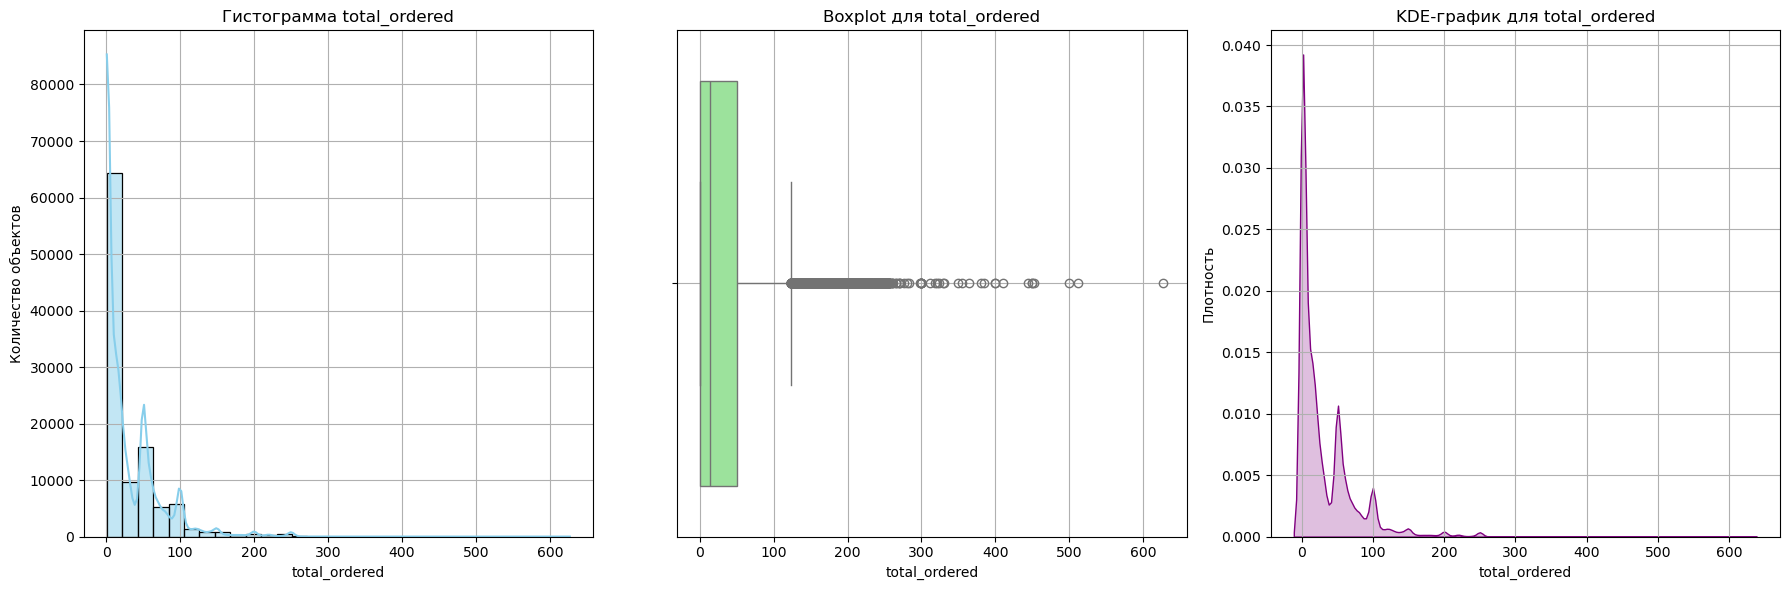

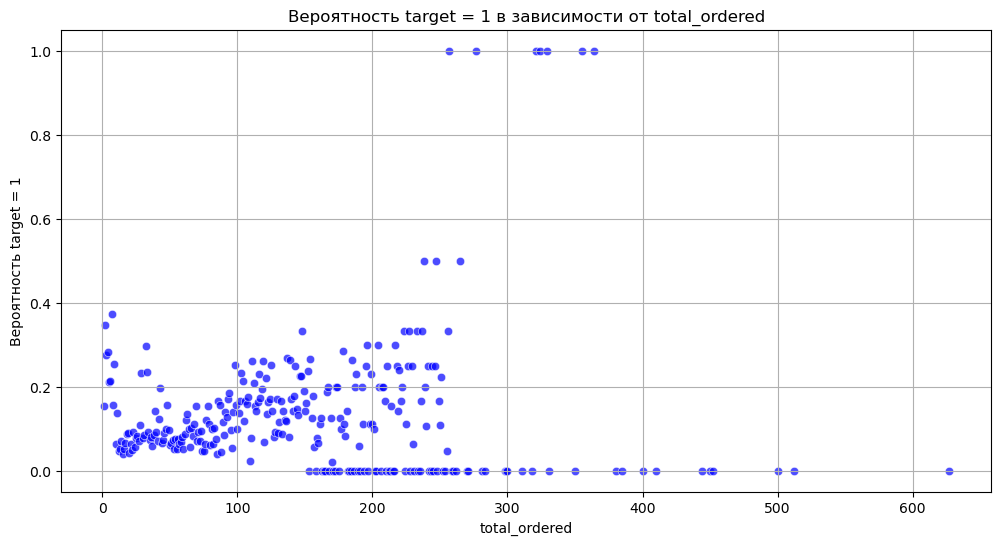

Статистика для признака 'count_items':
count    105565.000000
mean        256.541562
std        1023.116291
min           0.000000
25%           0.000000
50%          22.000000
75%         107.000000
max      203303.000000
Name: count_items, dtype: float64
Медиана: 22.0
0.95-й квантиль: 1205.0
0.85-й квантиль: 280.0


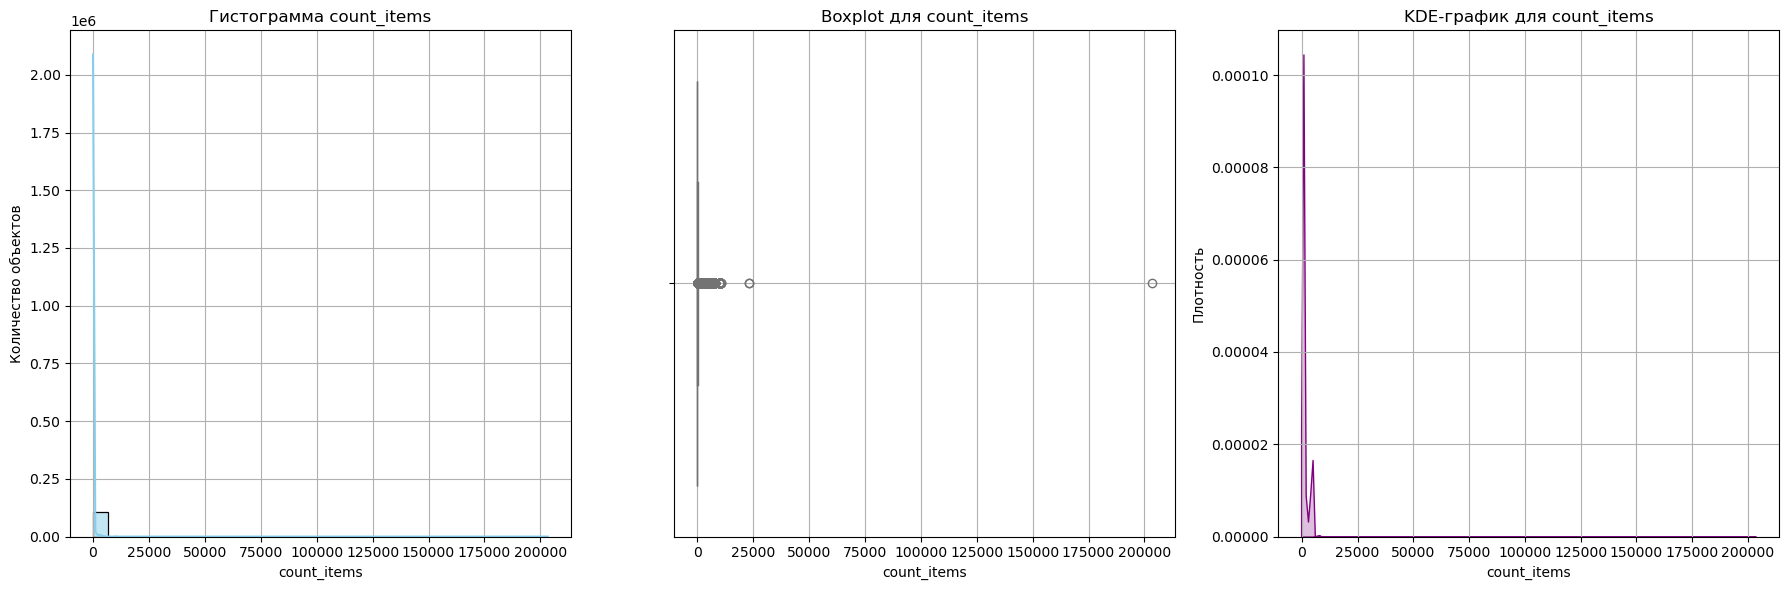

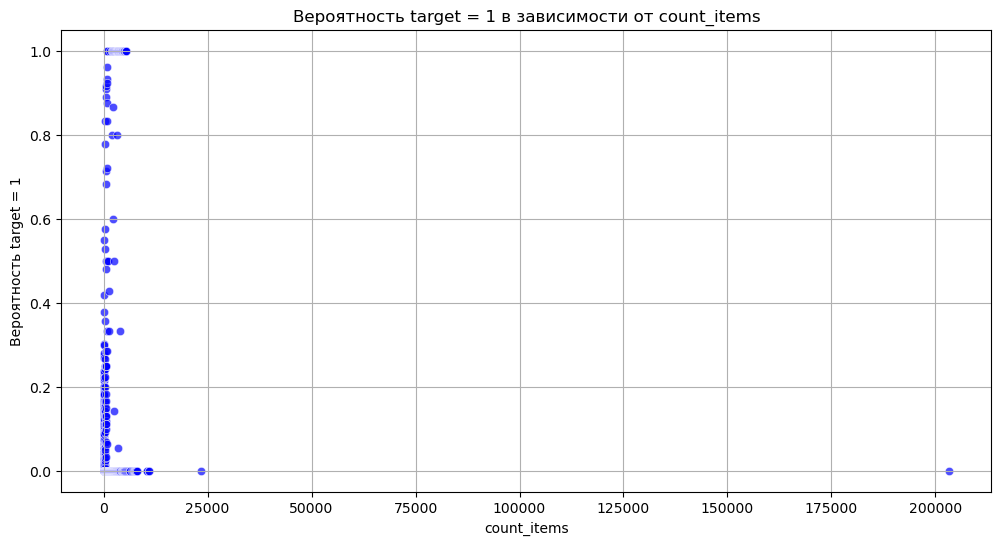

Статистика для признака 'unique_items':
count    105565.000000
mean         34.933851
std         141.116667
min           0.000000
25%           0.000000
50%          13.000000
75%          39.000000
max       19984.000000
Name: unique_items, dtype: float64
Медиана: 13.0
0.95-й квантиль: 119.0
0.85-й квантиль: 64.0


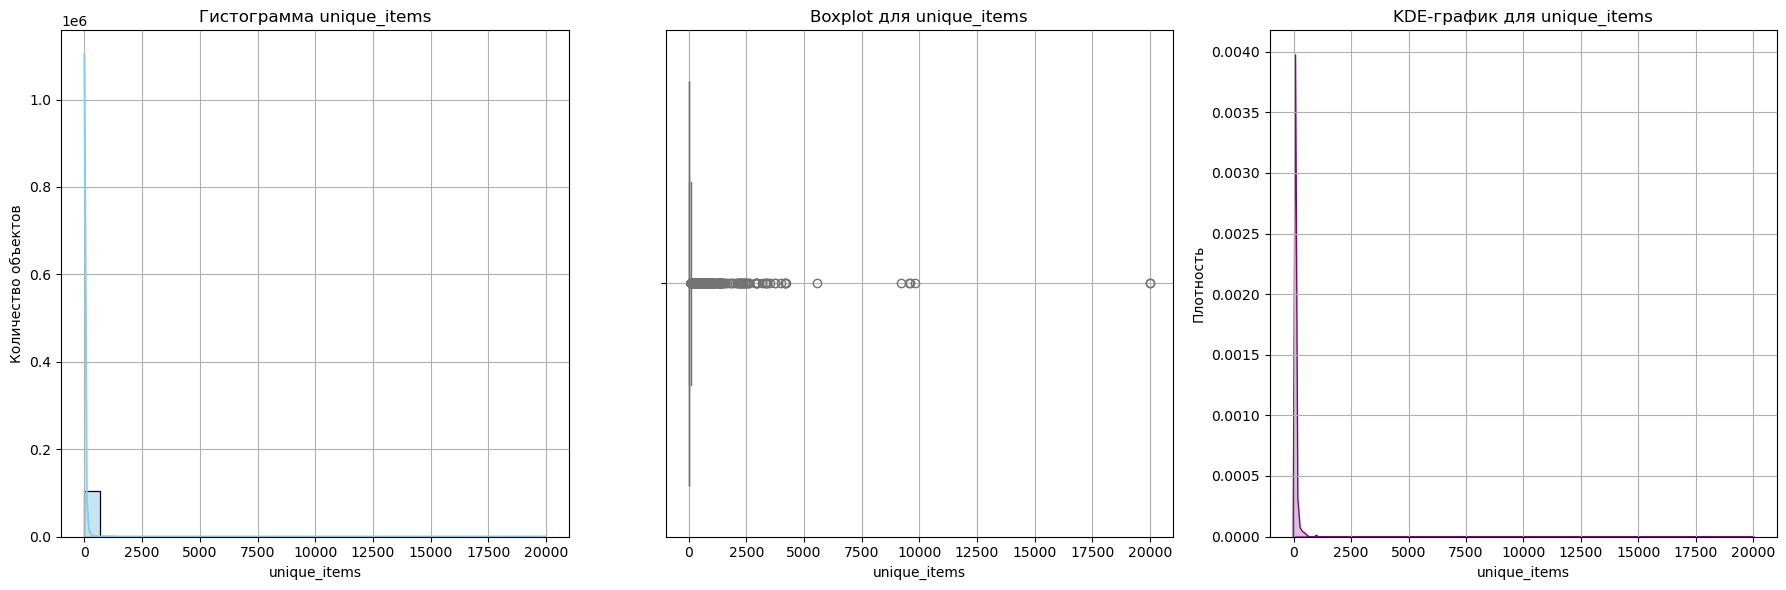

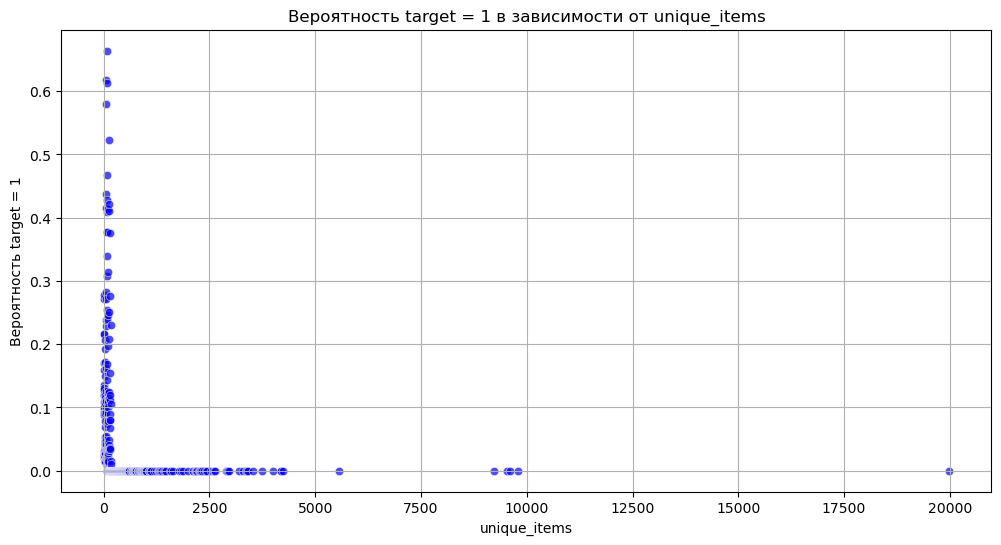

Статистика для признака 'NmAge':
count    105565.000000
mean       5518.167887
std        8667.012801
min           0.000000
25%         153.000000
50%         363.000000
75%       20004.000000
max       20120.000000
Name: NmAge, dtype: float64
Медиана: 363.0
0.95-й квантиль: 20079.0
0.85-й квантиль: 20053.0


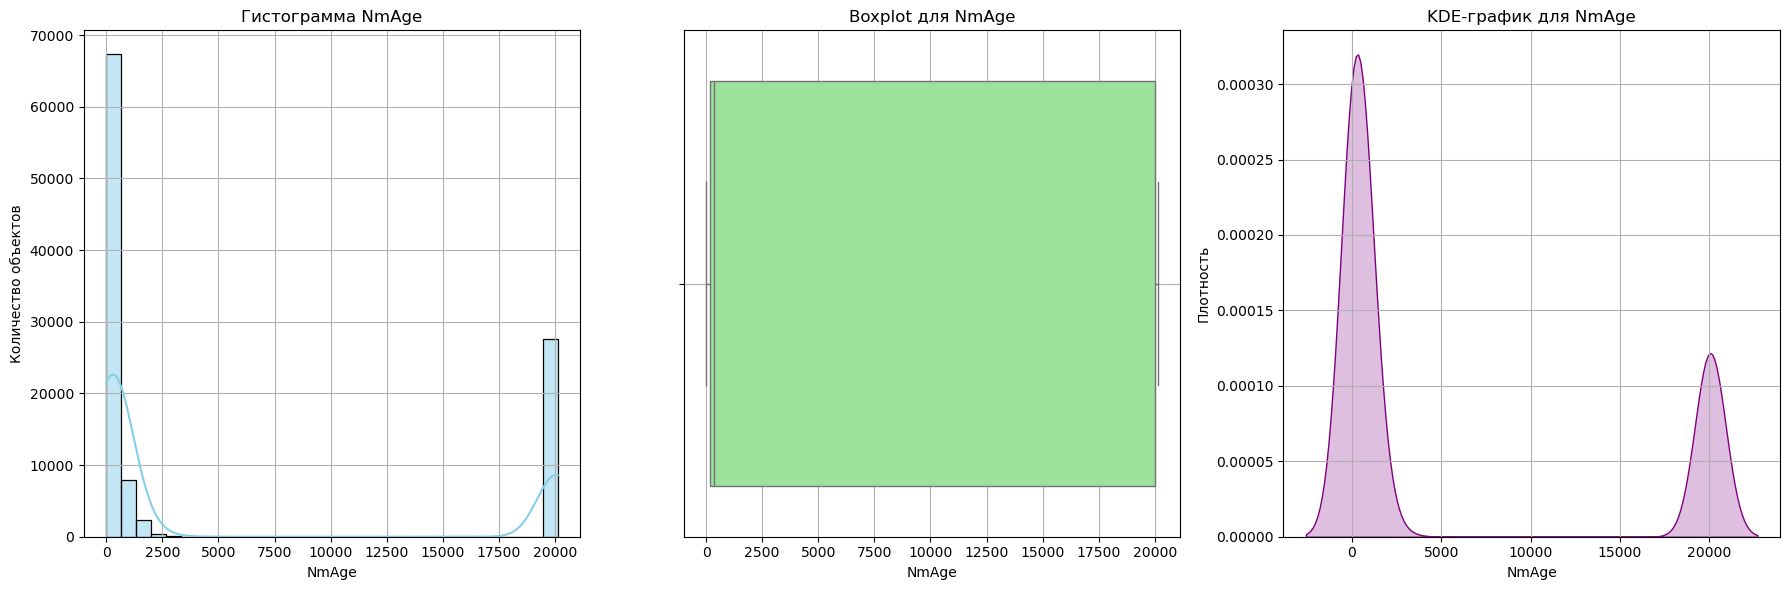

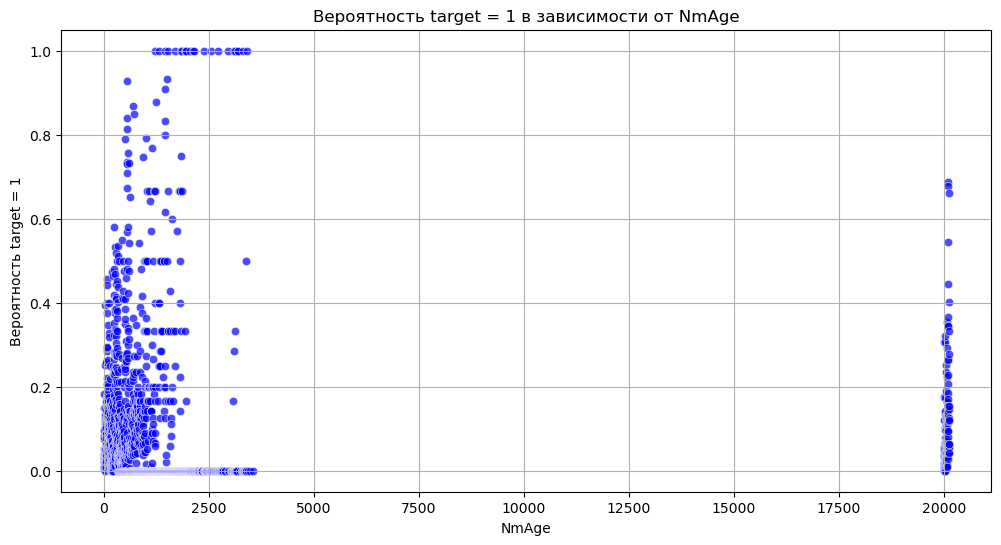

Статистика для признака 'Distance':
count    105565.000000
mean       1554.587572
std        1657.277528
min           6.000000
25%         472.000000
50%        1066.000000
75%        1995.000000
max       13381.000000
Name: Distance, dtype: float64
Медиана: 1066.0
0.95-й квантиль: 4653.0
0.85-й квантиль: 2889.0


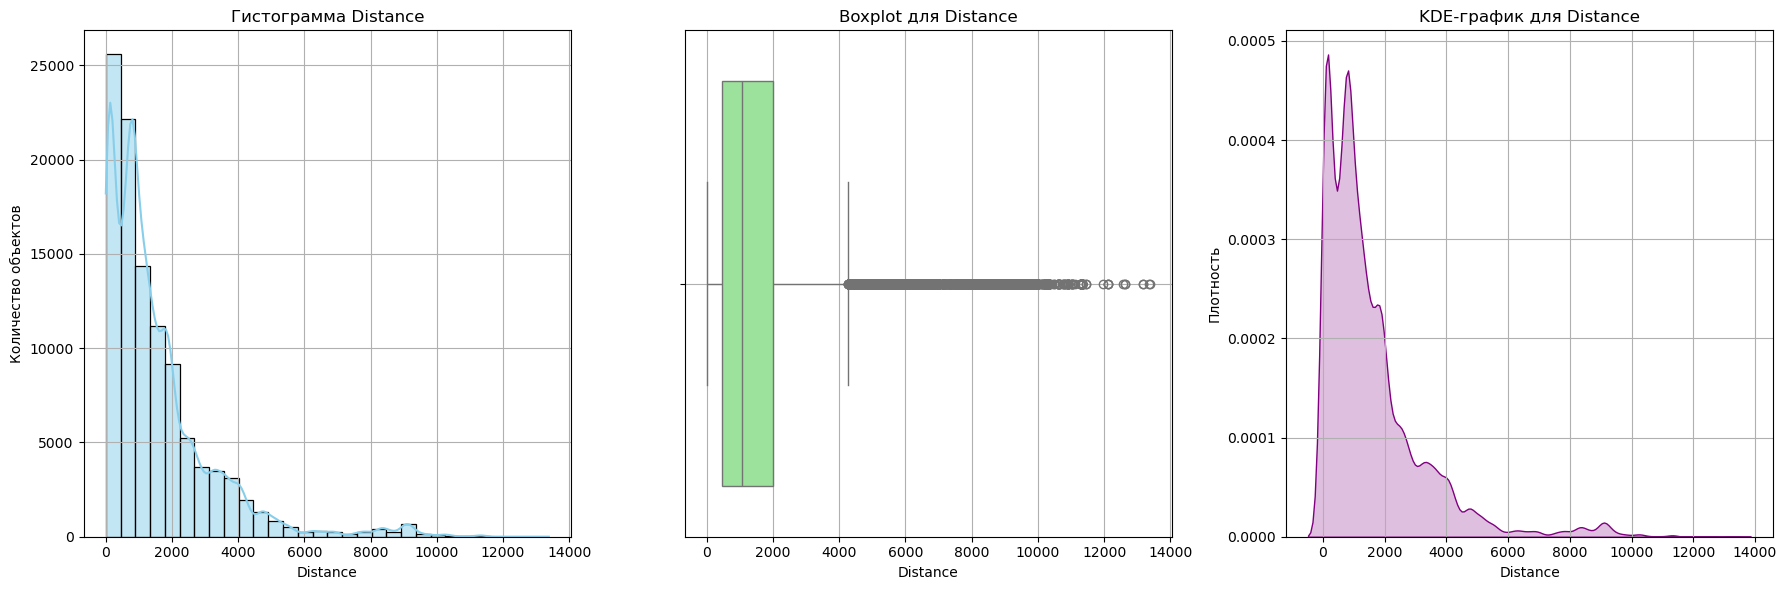

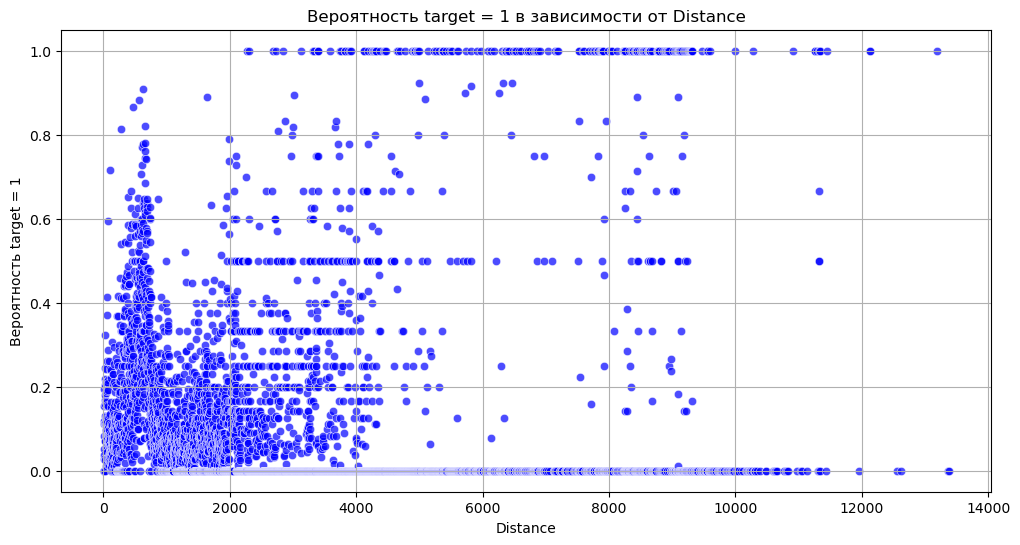

Статистика для признака 'DaysAfterRegistration':
count    105565.000000
mean       1368.405589
std         995.599647
min           0.000000
25%         551.000000
50%        1344.000000
75%        1843.000000
max        5839.000000
Name: DaysAfterRegistration, dtype: float64
Медиана: 1344.0
0.95-й квантиль: 3341.0
0.85-й квантиль: 2265.0


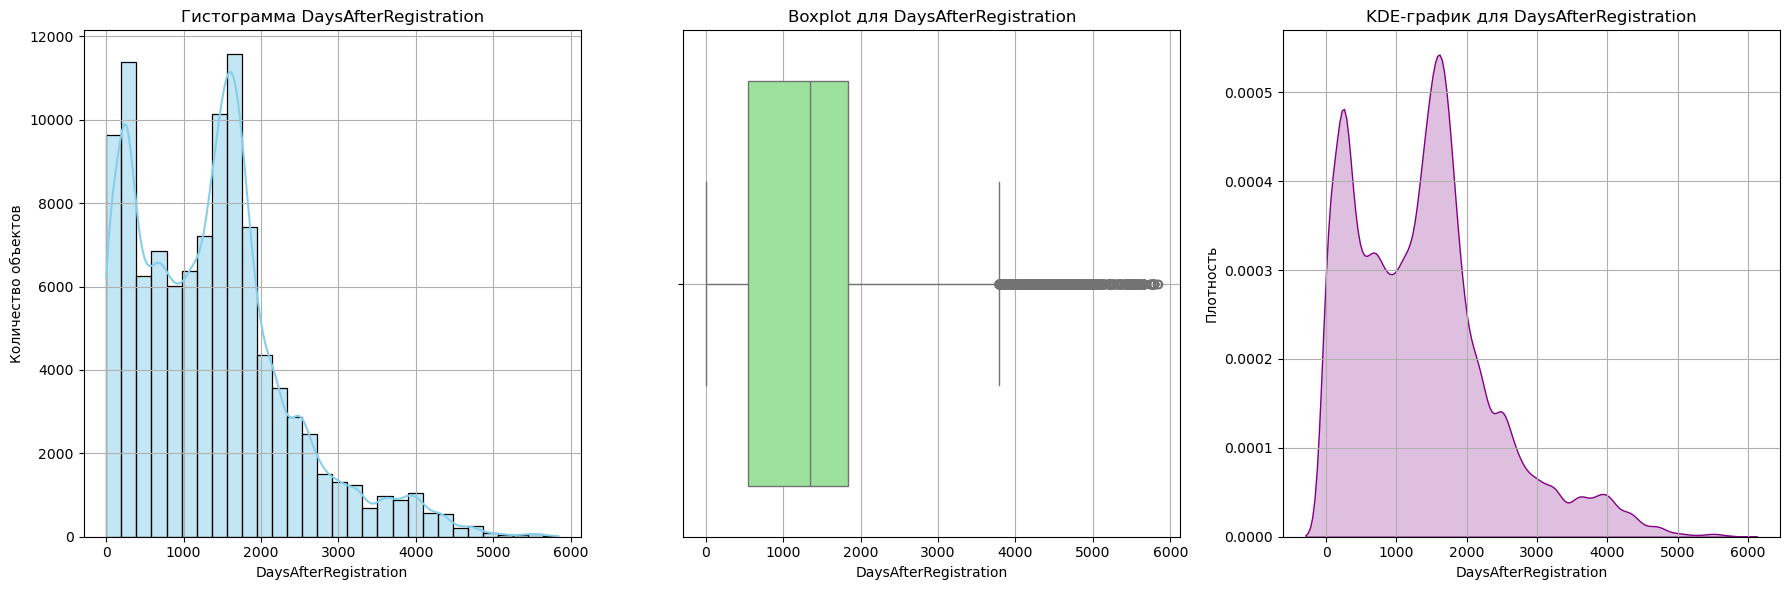

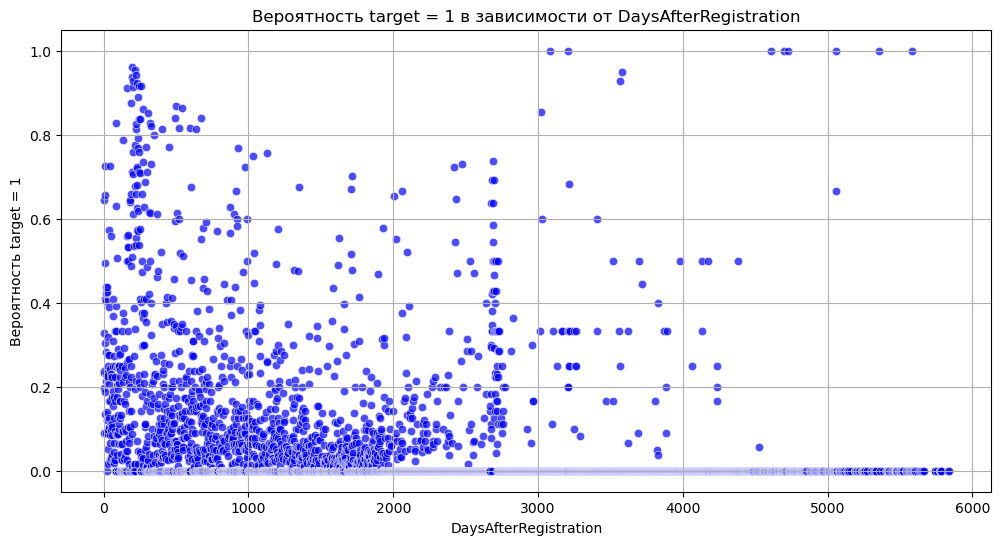

Статистика для признака 'number_of_orders':
count    105565.000000
mean         20.504665
std          58.990701
min           1.000000
25%           1.000000
50%           3.000000
75%          22.000000
max        2384.000000
Name: number_of_orders, dtype: float64
Медиана: 3.0
0.95-й квантиль: 79.0
0.85-й квантиль: 51.0


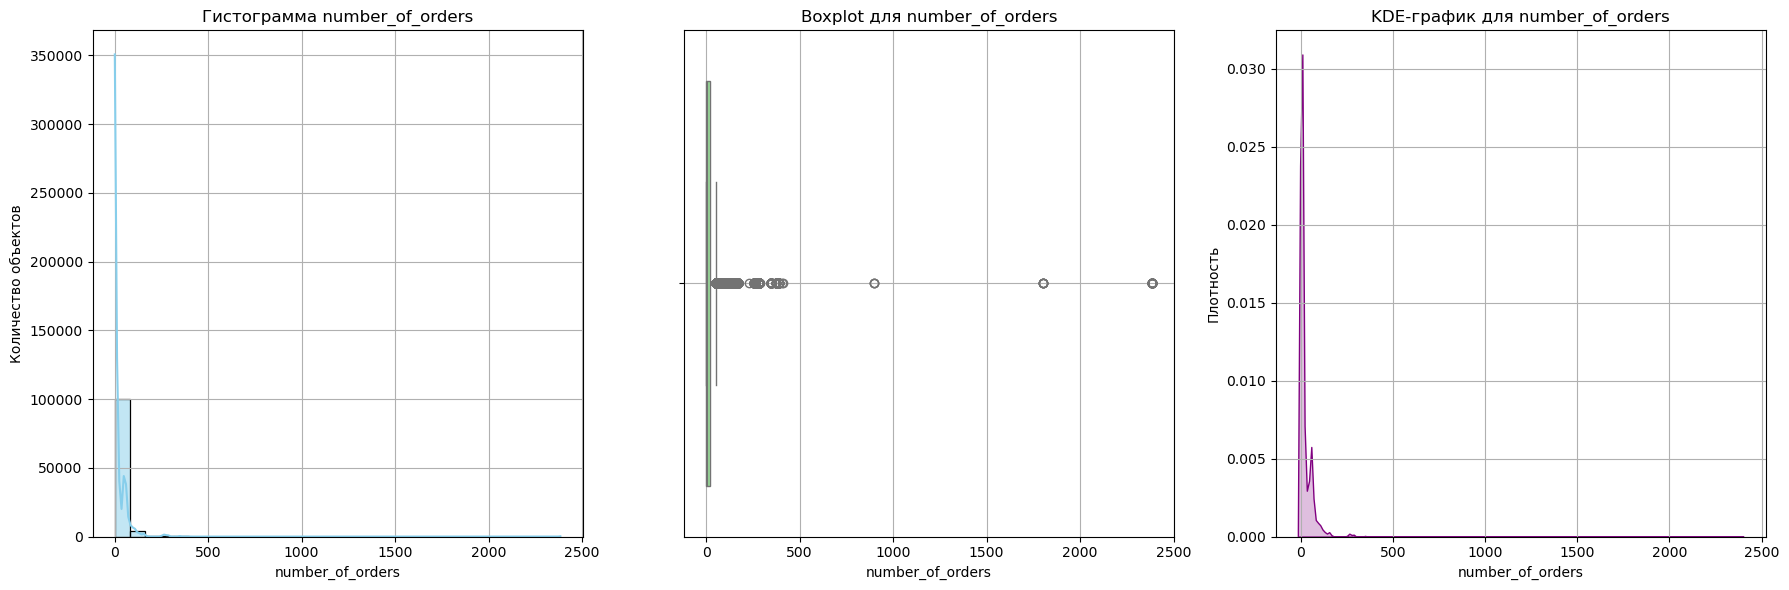

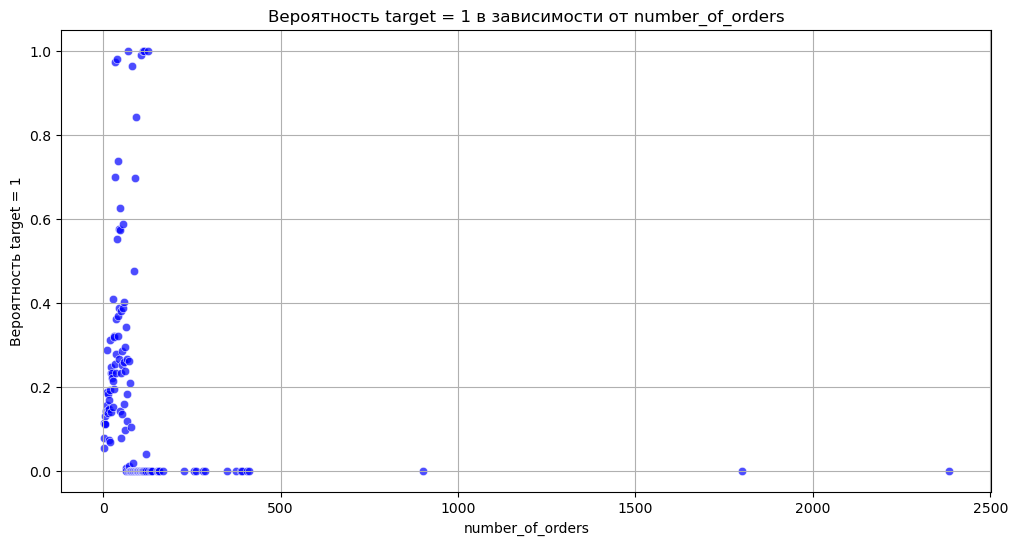

Статистика для признака 'number_of_ordered_items':
count    105565.000000
mean        145.566902
std        2196.753376
min           1.000000
25%          27.000000
50%          56.000000
75%          94.000000
max      385200.000000
Name: number_of_ordered_items, dtype: float64
Медиана: 56.0
0.95-й квантиль: 282.0
0.85-й квантиль: 126.0


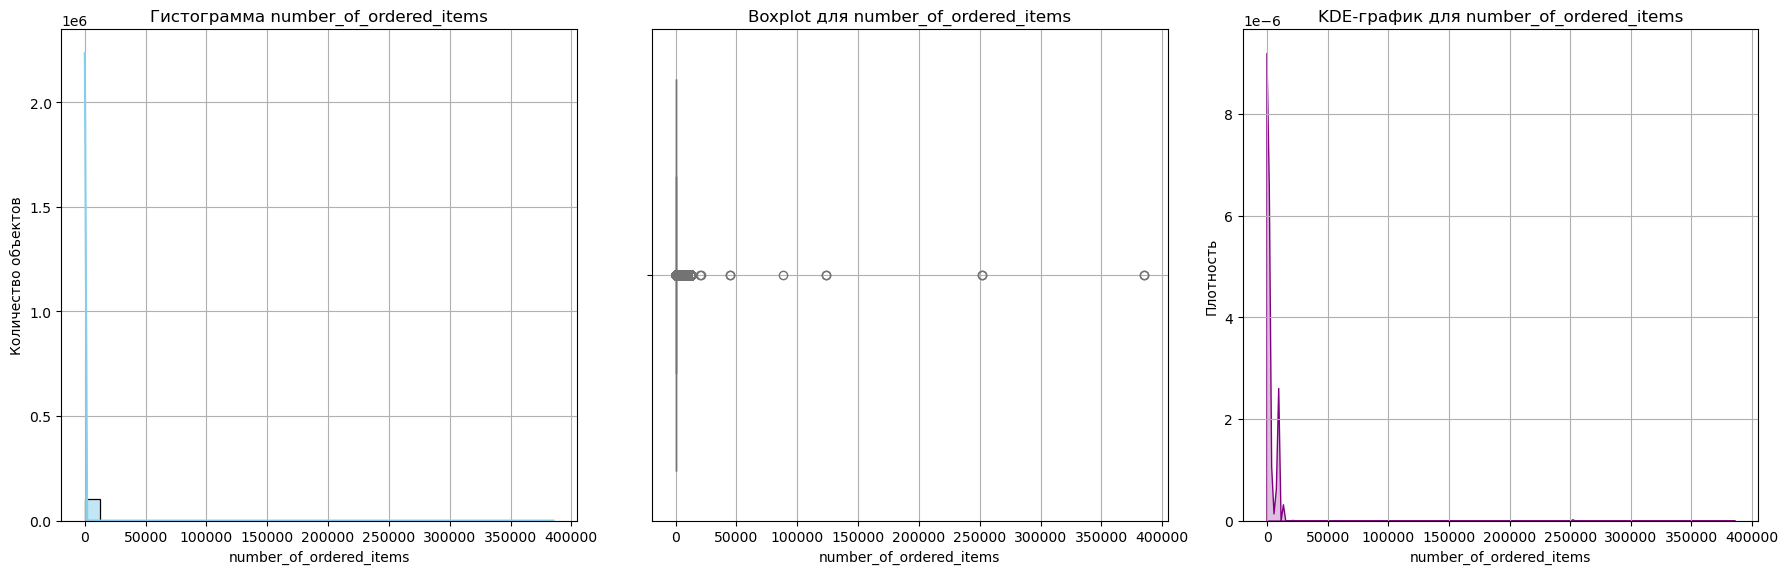

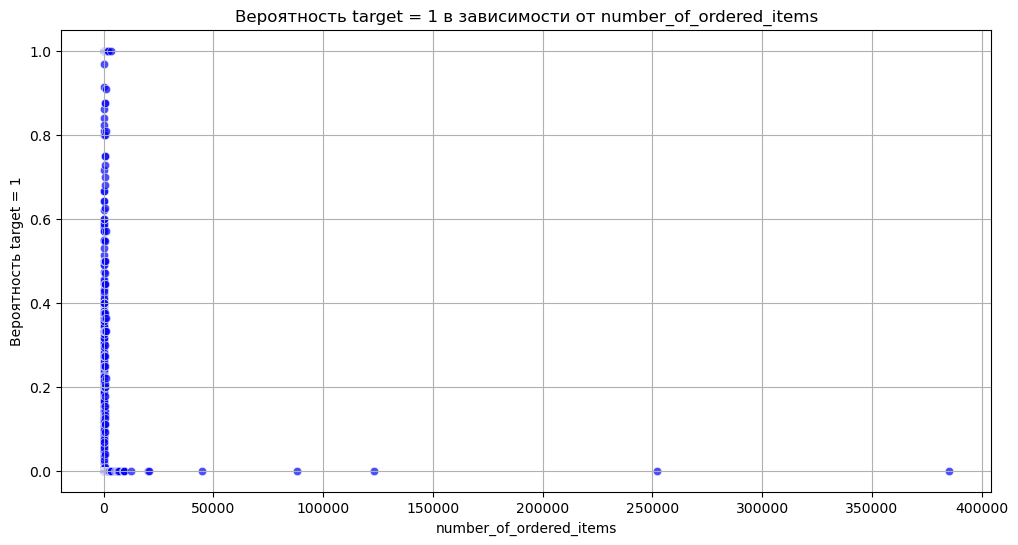

Статистика для признака 'mean_number_of_ordered_items':
count    105565.000000
mean         30.249259
std          38.607053
min           1.000000
25%           1.649123
50%          15.000000
75%          50.000000
max         627.000000
Name: mean_number_of_ordered_items, dtype: float64
Медиана: 15.0
0.95-й квантиль: 100.0
0.85-й квантиль: 62.0


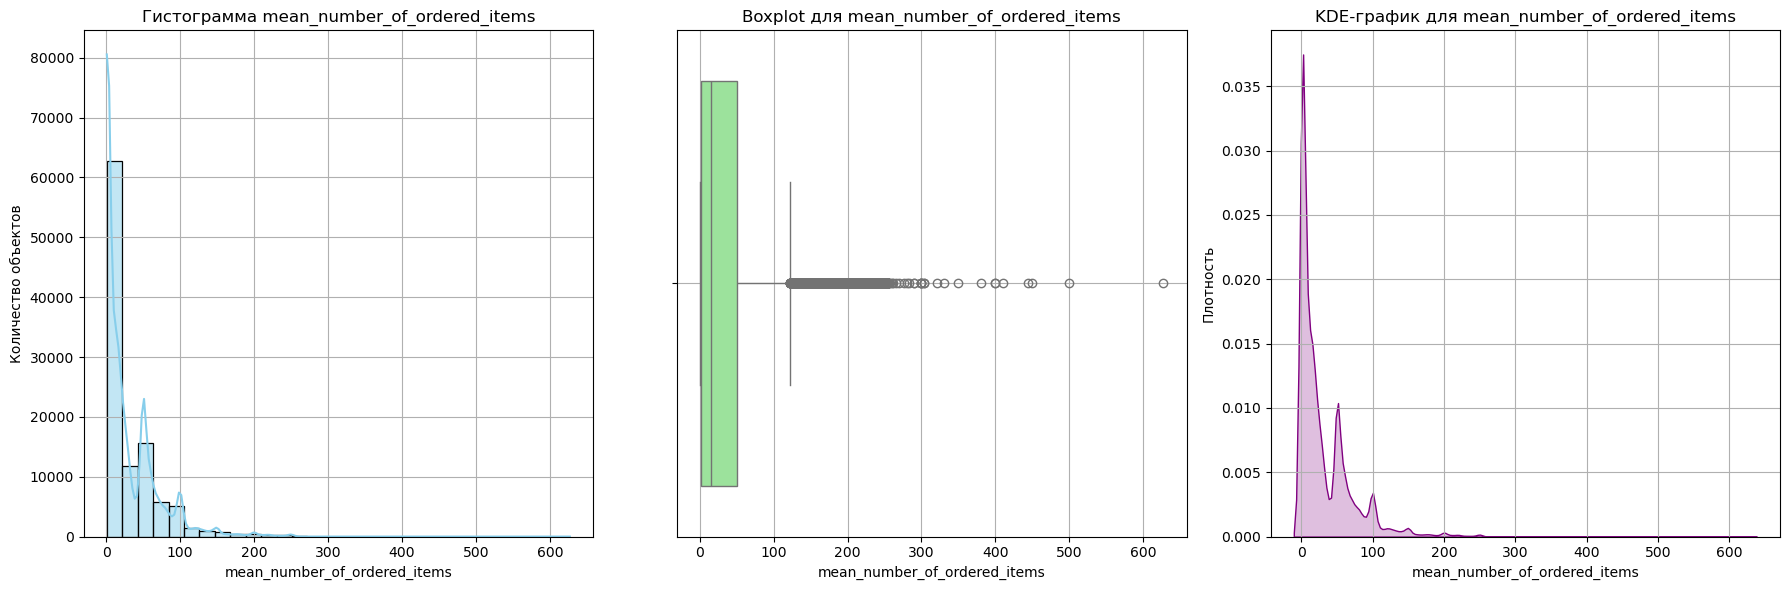

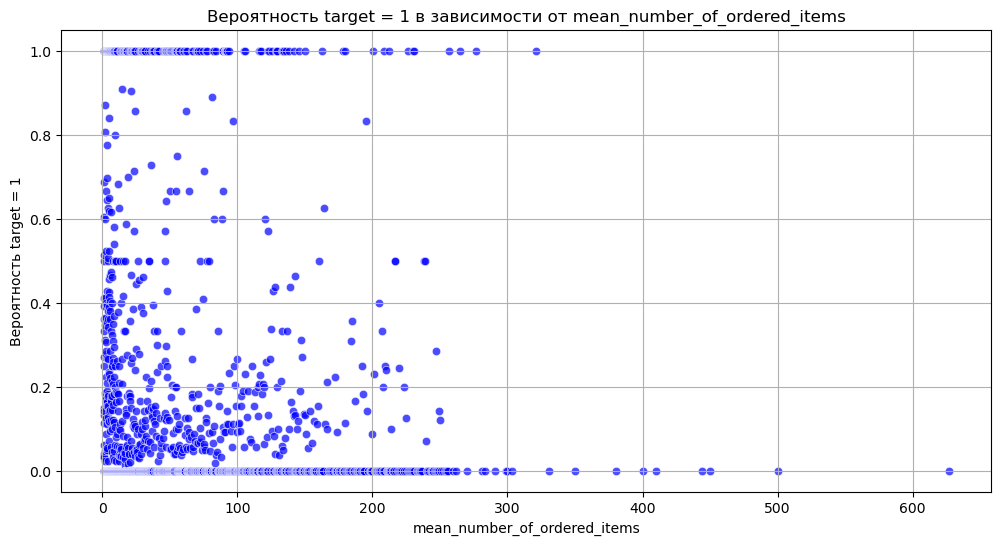

Статистика для признака 'min_number_of_ordered_items':
count    105565.000000
mean         25.561417
std          36.717645
min           1.000000
25%           1.000000
50%          10.000000
75%          50.000000
max         627.000000
Name: min_number_of_ordered_items, dtype: float64
Медиана: 10.0
0.95-й квантиль: 100.0
0.85-й квантиль: 58.0


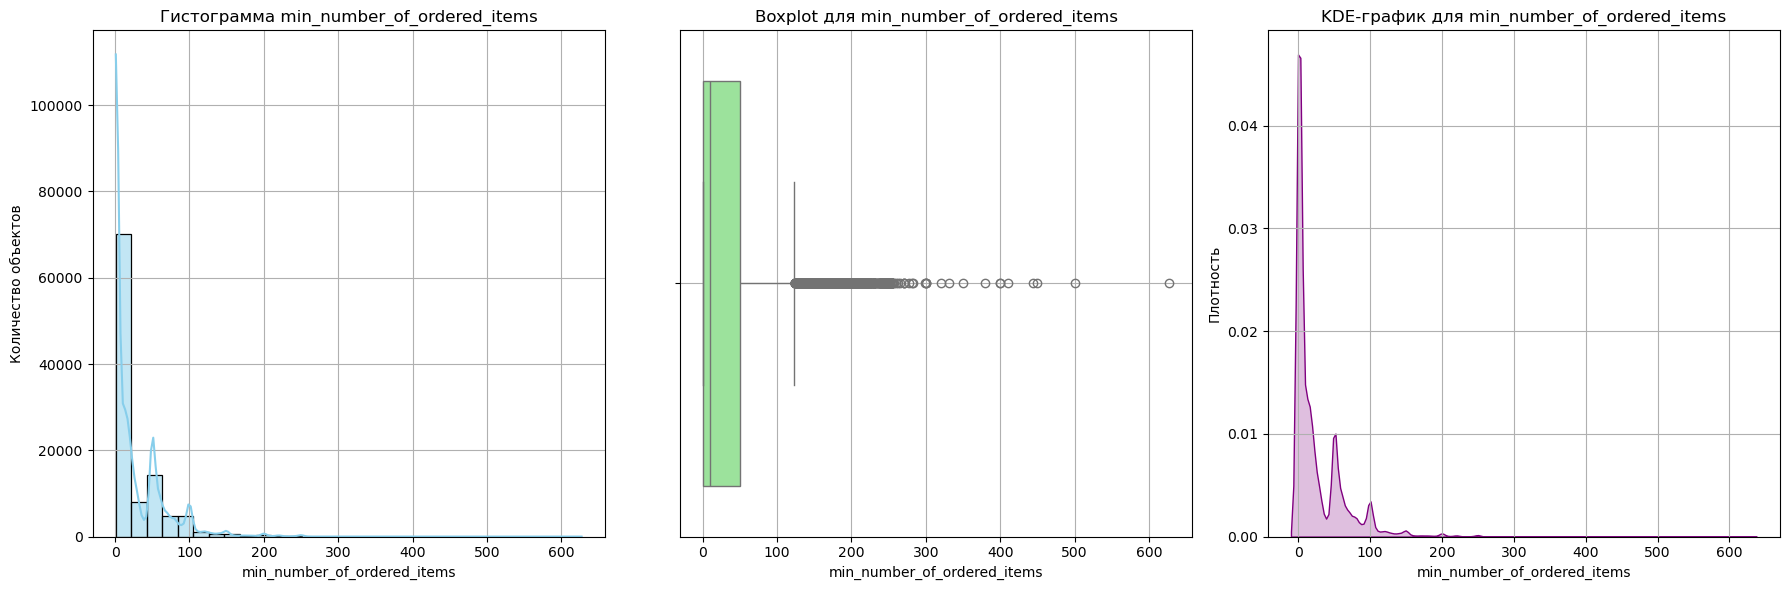

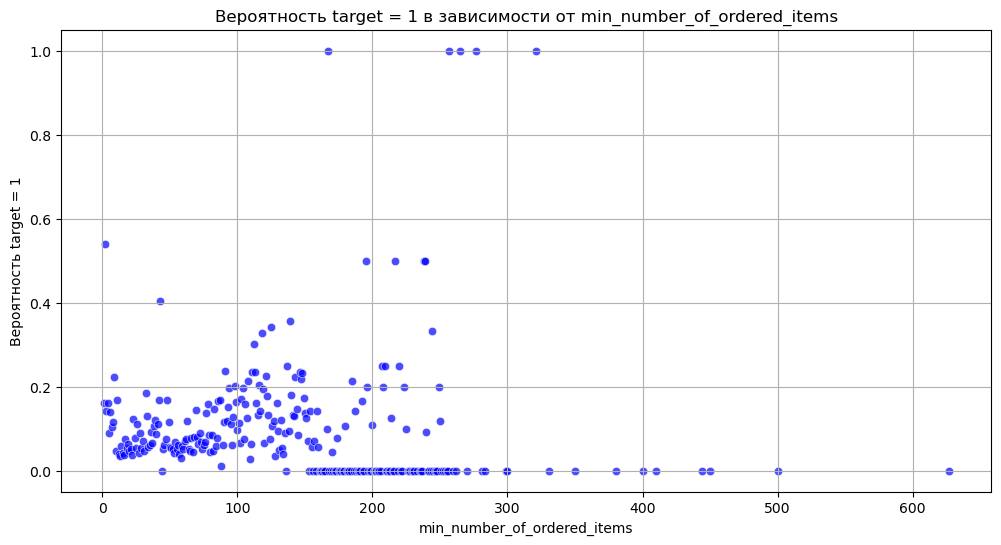

Статистика для признака 'max_number_of_ordered_items':
count    105565.000000
mean         36.207900
std          44.659212
min           1.000000
25%           3.000000
50%          20.000000
75%          50.000000
max         627.000000
Name: max_number_of_ordered_items, dtype: float64
Медиана: 20.0
0.95-й квантиль: 116.0
0.85-й квантиль: 72.0


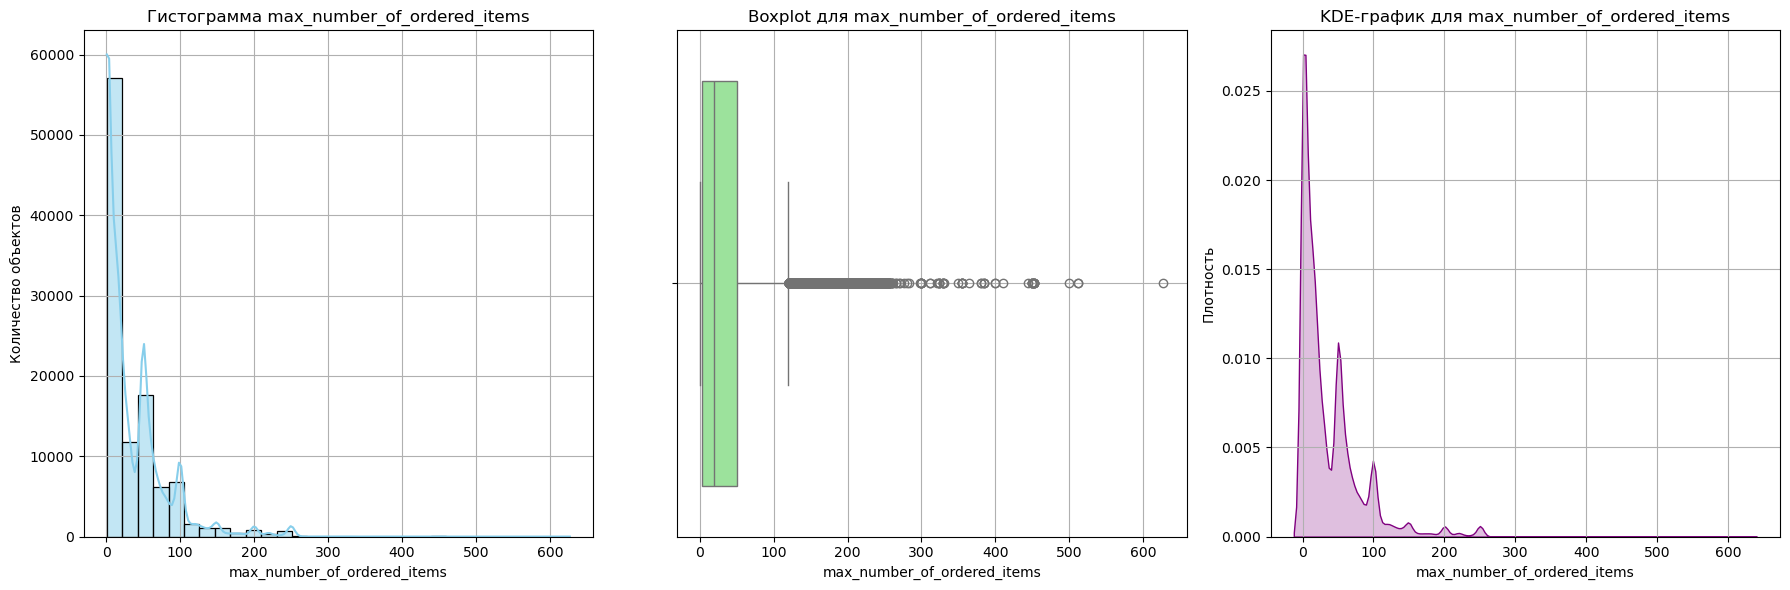

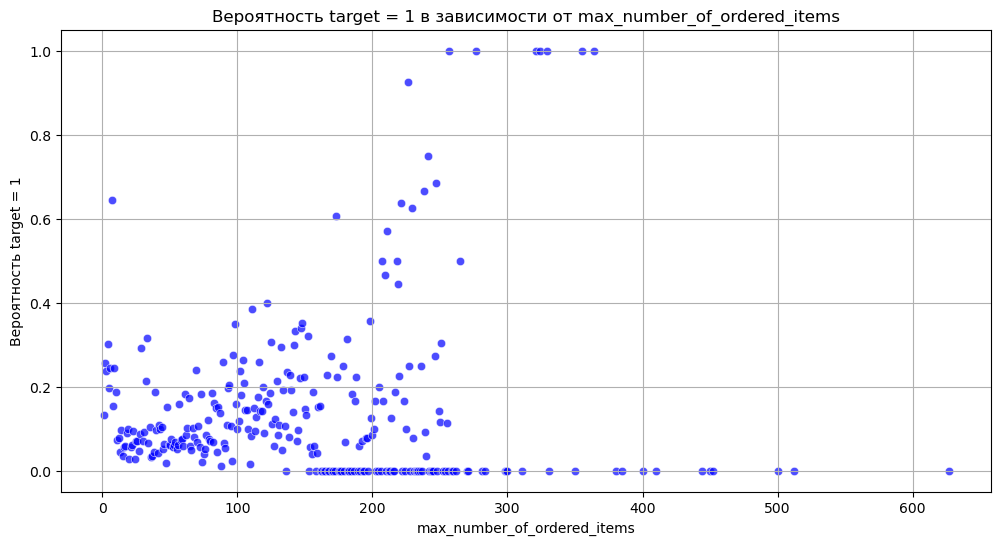

In [3]:
#Визуализация необратоннаых данных
df=get_df("df_train")
for feature in ['total_ordered', 'count_items','unique_items','NmAge','Distance','DaysAfterRegistration','number_of_orders','number_of_ordered_items','mean_number_of_ordered_items', 'min_number_of_ordered_items','max_number_of_ordered_items']:
    draw_graphs(df, feature)

In [4]:
#Датасет с починкой выбросов и улучшением структуры df
df=get_df("df_train")
for feature in ['total_ordered', 'count_items','unique_items','NmAge','Distance','DaysAfterRegistration','number_of_orders','number_of_ordered_items','mean_number_of_ordered_items', 'min_number_of_ordered_items','max_number_of_ordered_items']:
    df=fix_outlier(df, feature)
df=adapt_df(df)
save_df(df, "train_prep")

DataFrame успешно сохранён в файл: train_prep.csv


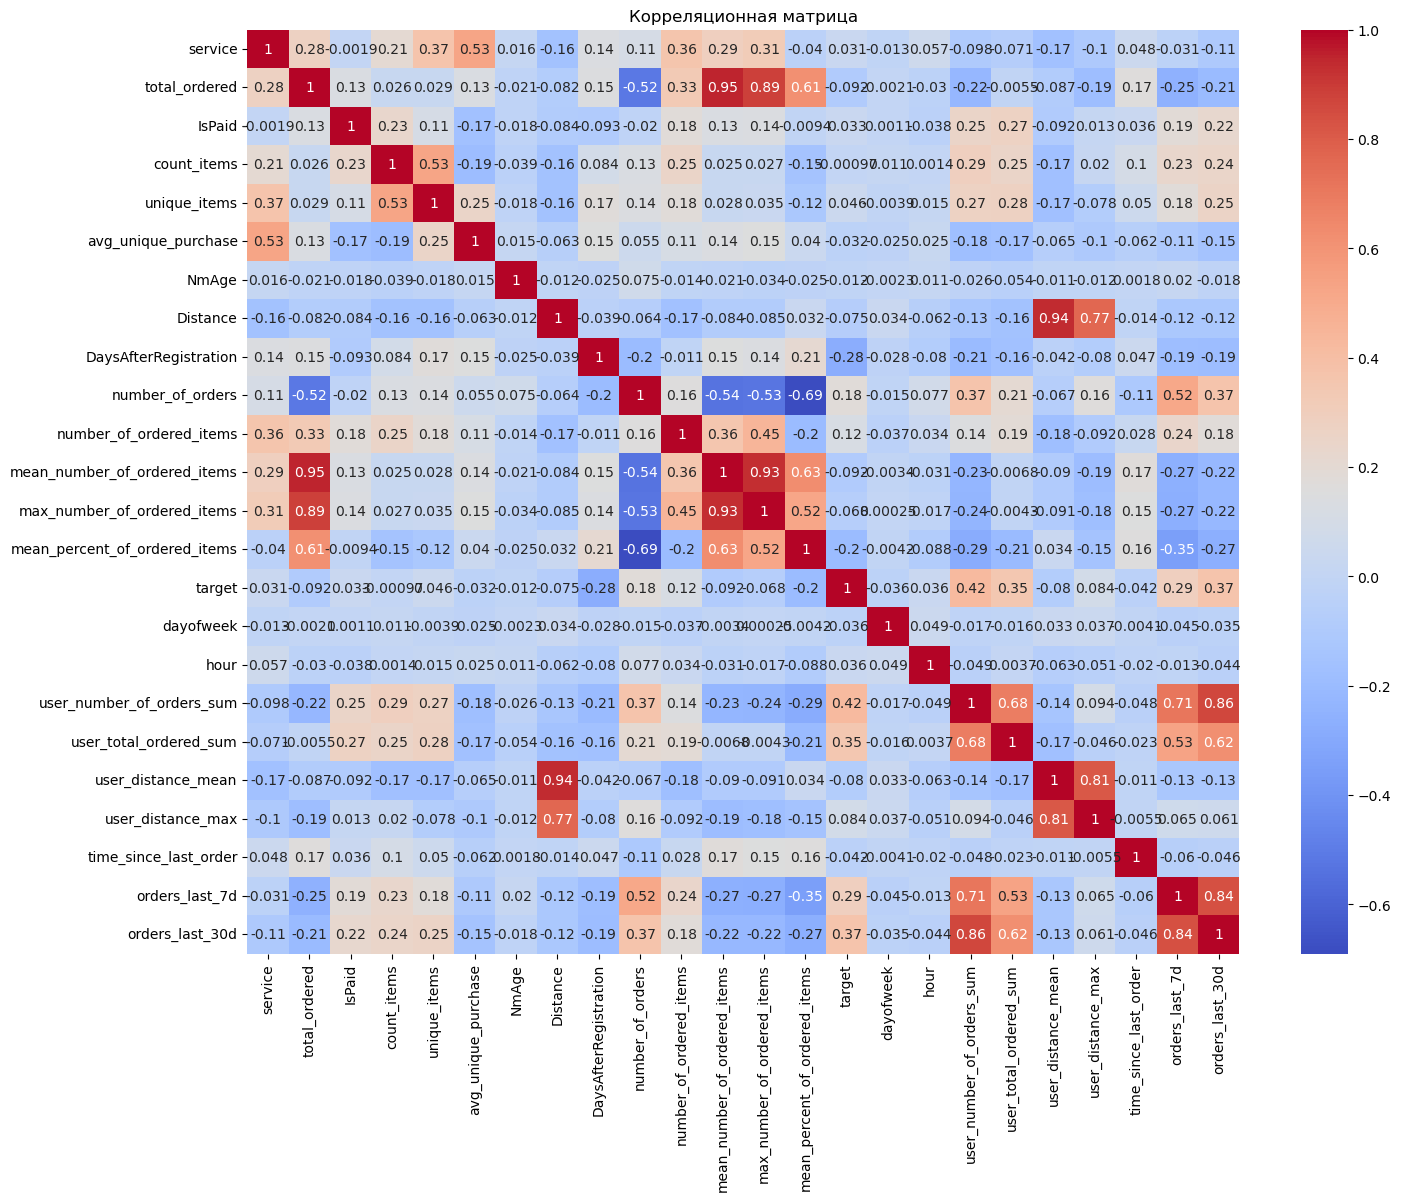

In [5]:
#Матрица корреляций обработанных данных
df=get_df("train_prep")
df=df.drop(columns=['PaymentType'])
corr(df)

Статистика для признака 'service':
count    105565.000000
mean          0.705887
std           0.455645
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: service, dtype: float64
Медиана: 1.0
0.95-й квантиль: 1.0
0.85-й квантиль: 1.0


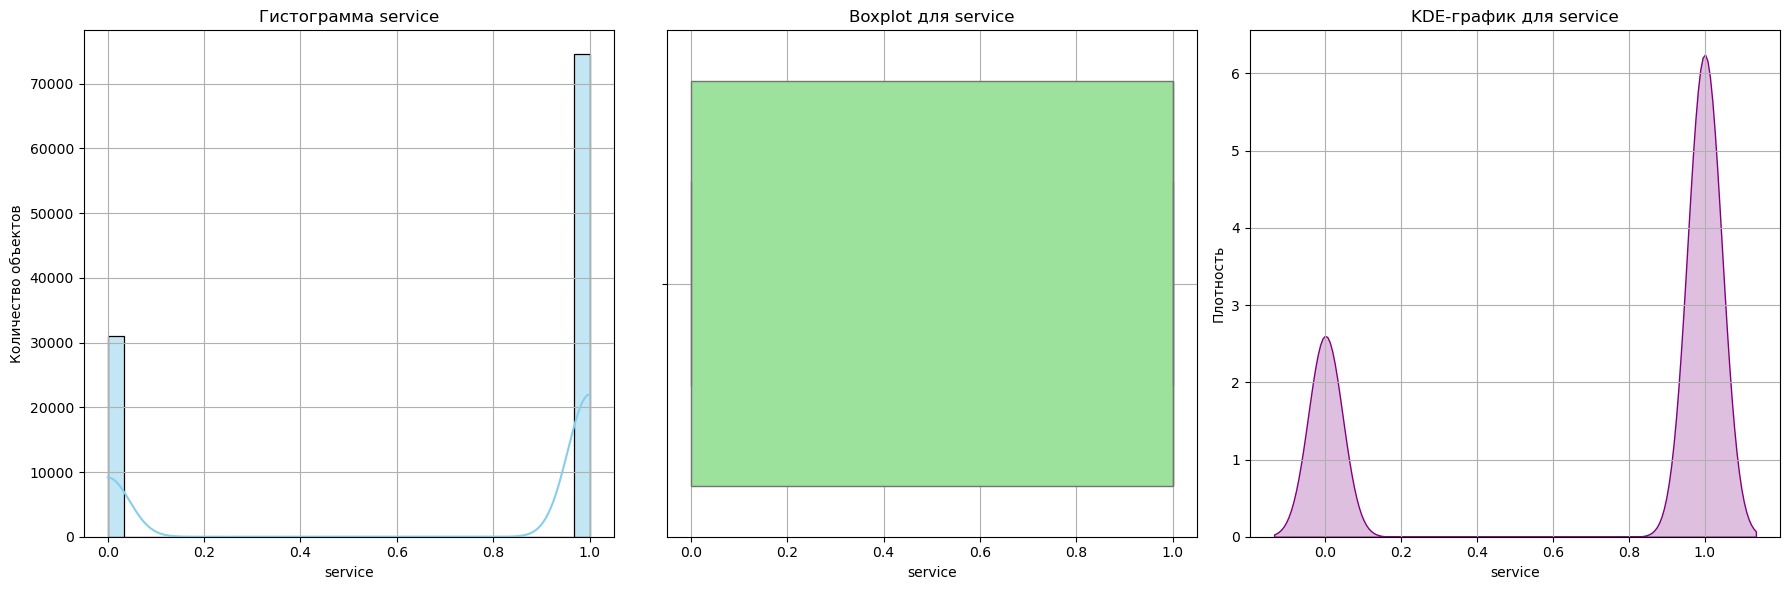

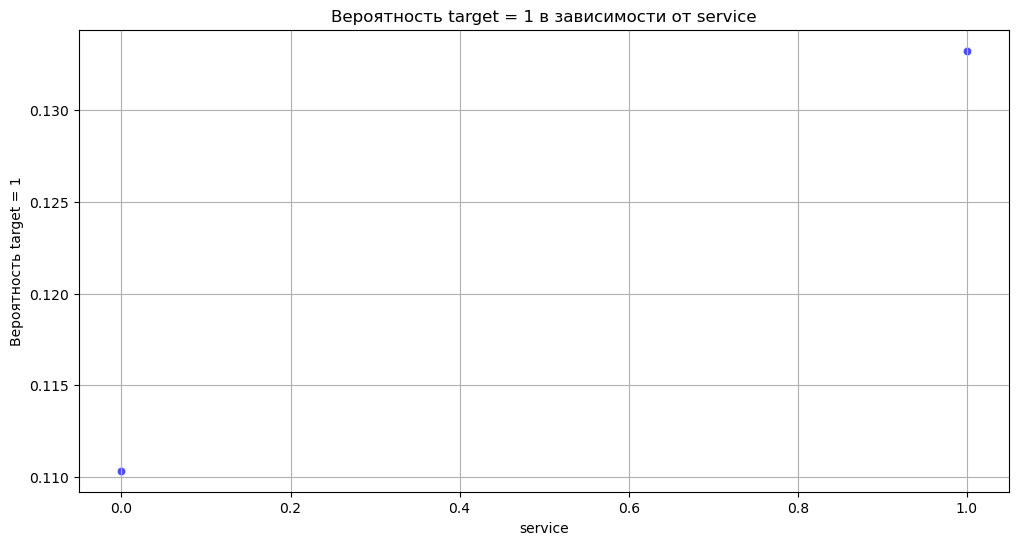

Статистика для признака 'total_ordered':
count    105565.000000
mean         25.823123
std          28.528270
min           1.000000
25%           1.000000
50%          14.000000
75%          50.000000
max         100.000000
Name: total_ordered, dtype: float64
Медиана: 14.0
0.95-й квантиль: 84.0
0.85-й квантиль: 63.0


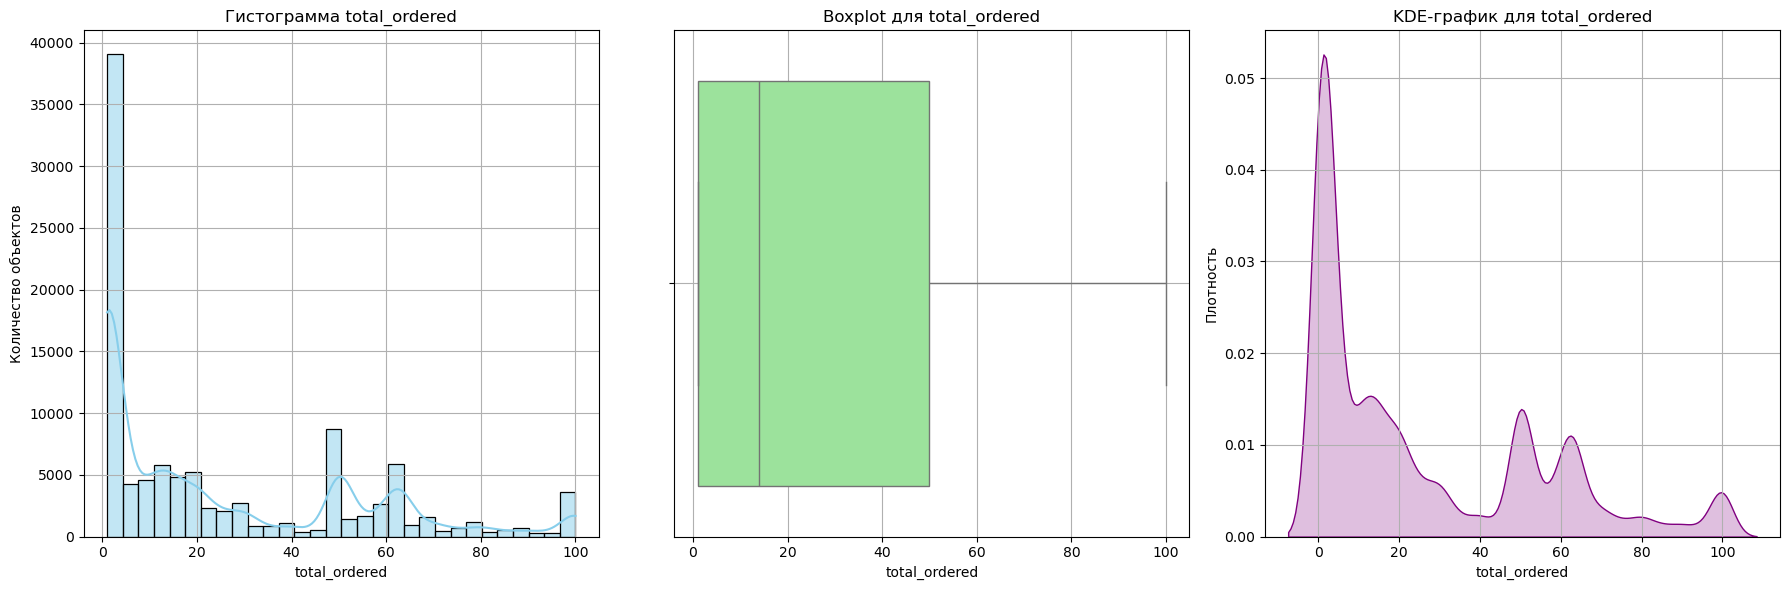

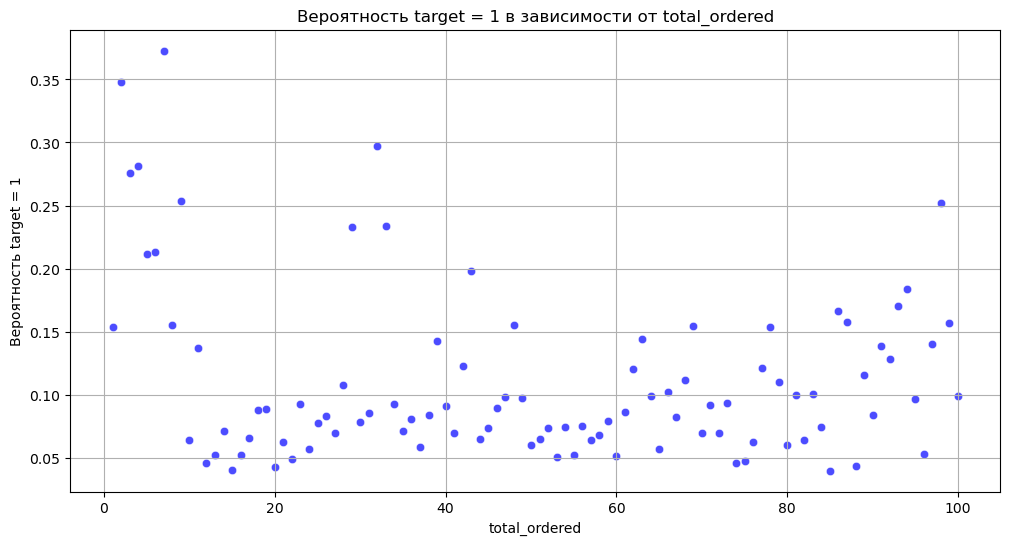

Статистика для признака 'count_items':
count    105565.000000
mean        102.270459
std         183.797256
min           0.000000
25%           0.000000
50%          22.000000
75%         107.000000
max        1205.000000
Name: count_items, dtype: float64
Медиана: 22.0
0.95-й квантиль: 529.0
0.85-й квантиль: 280.0


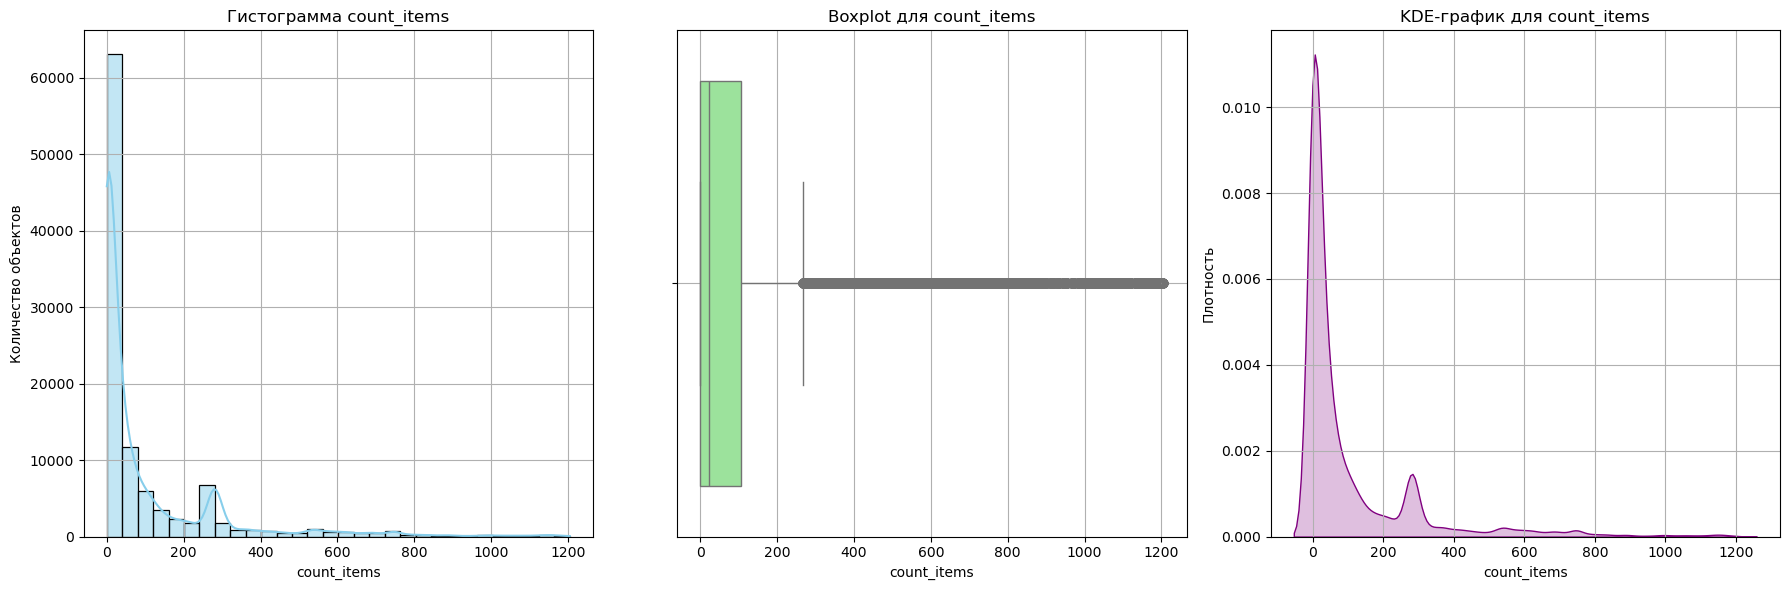

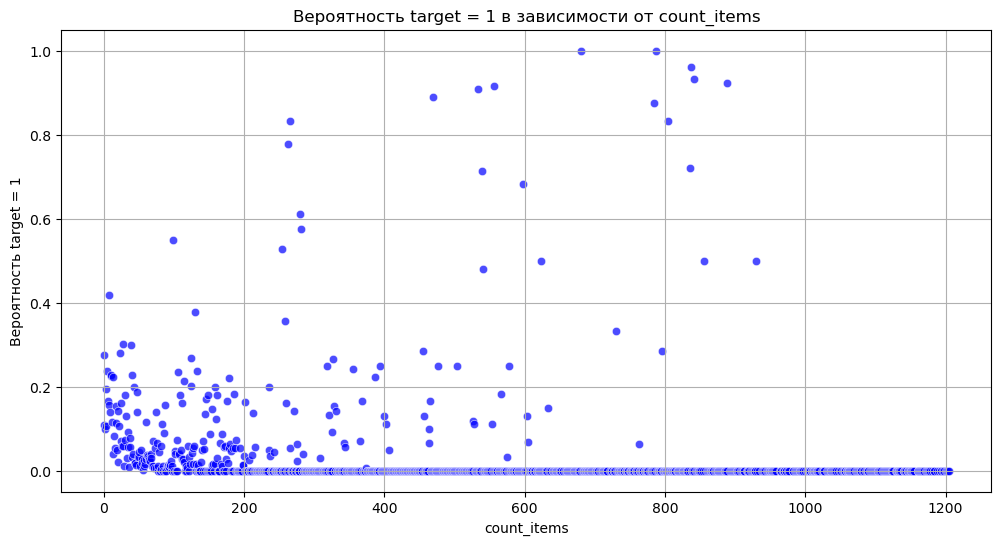

Статистика для признака 'unique_items':
count    105565.000000
mean         23.690485
std          27.786520
min           0.000000
25%           0.000000
50%          13.000000
75%          39.000000
max         119.000000
Name: unique_items, dtype: float64
Медиана: 13.0
0.95-й квантиль: 78.0
0.85-й квантиль: 64.0


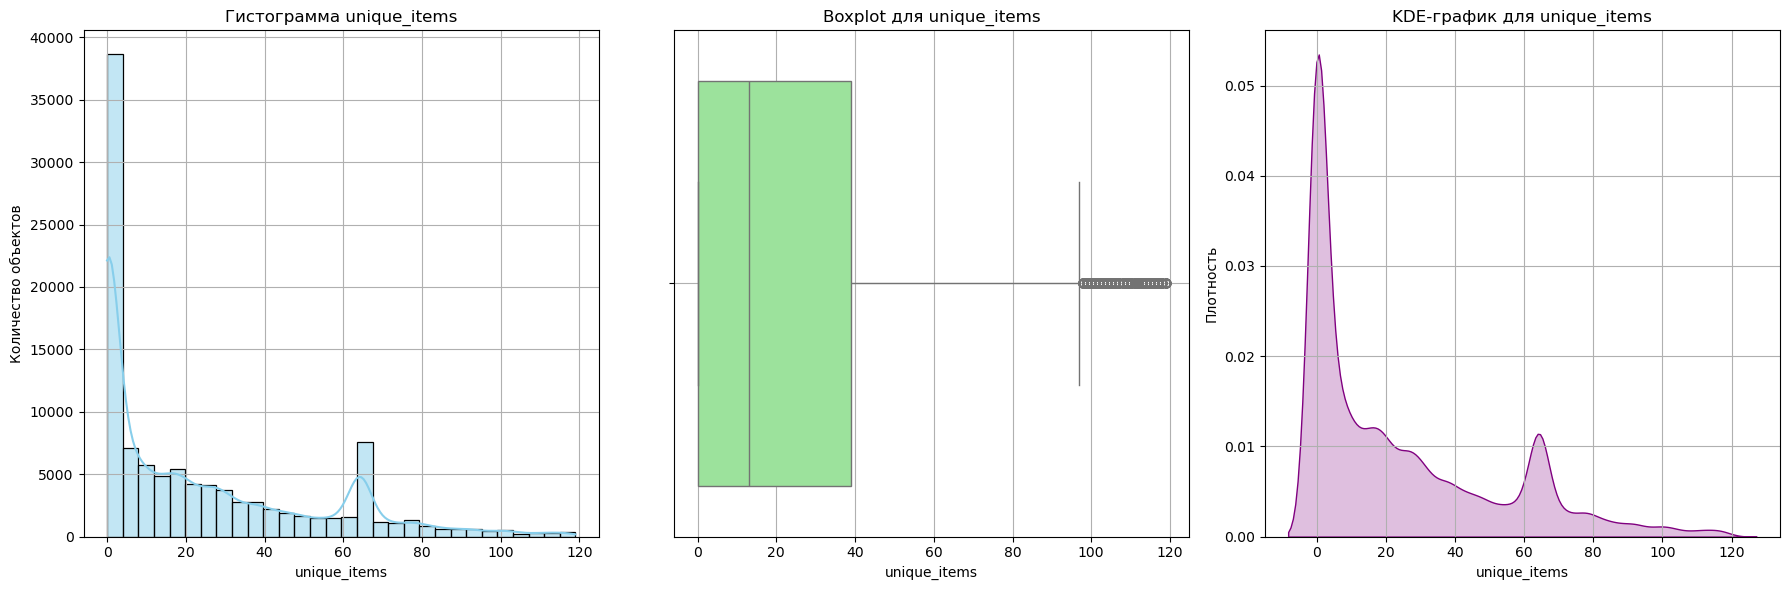

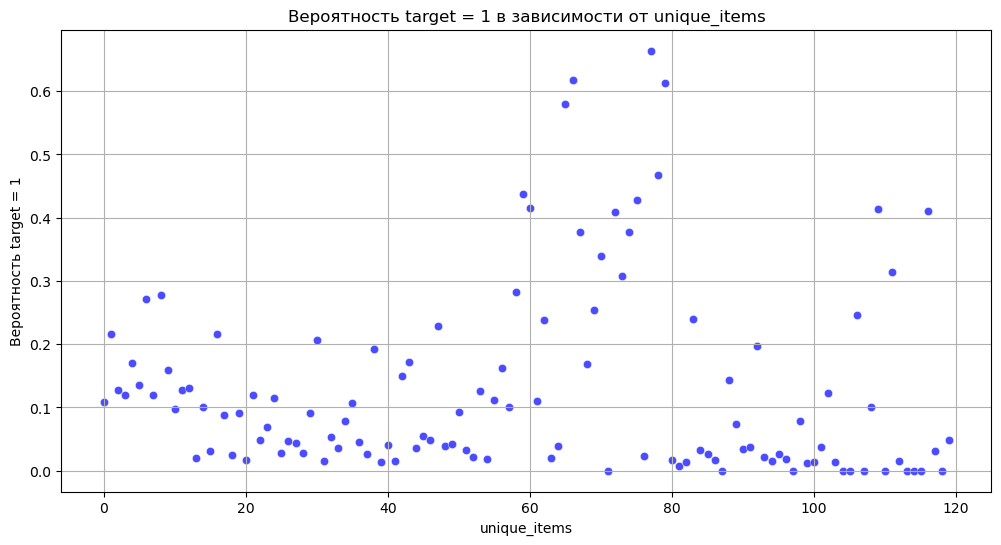

Статистика для признака 'avg_unique_purchase':
count    105565.000000
mean          0.403886
std           0.406656
min           0.000000
25%           0.000000
50%           0.250000
75%           0.860000
max           1.000000
Name: avg_unique_purchase, dtype: float64
Медиана: 0.25
0.95-й квантиль: 1.0
0.85-й квантиль: 0.96


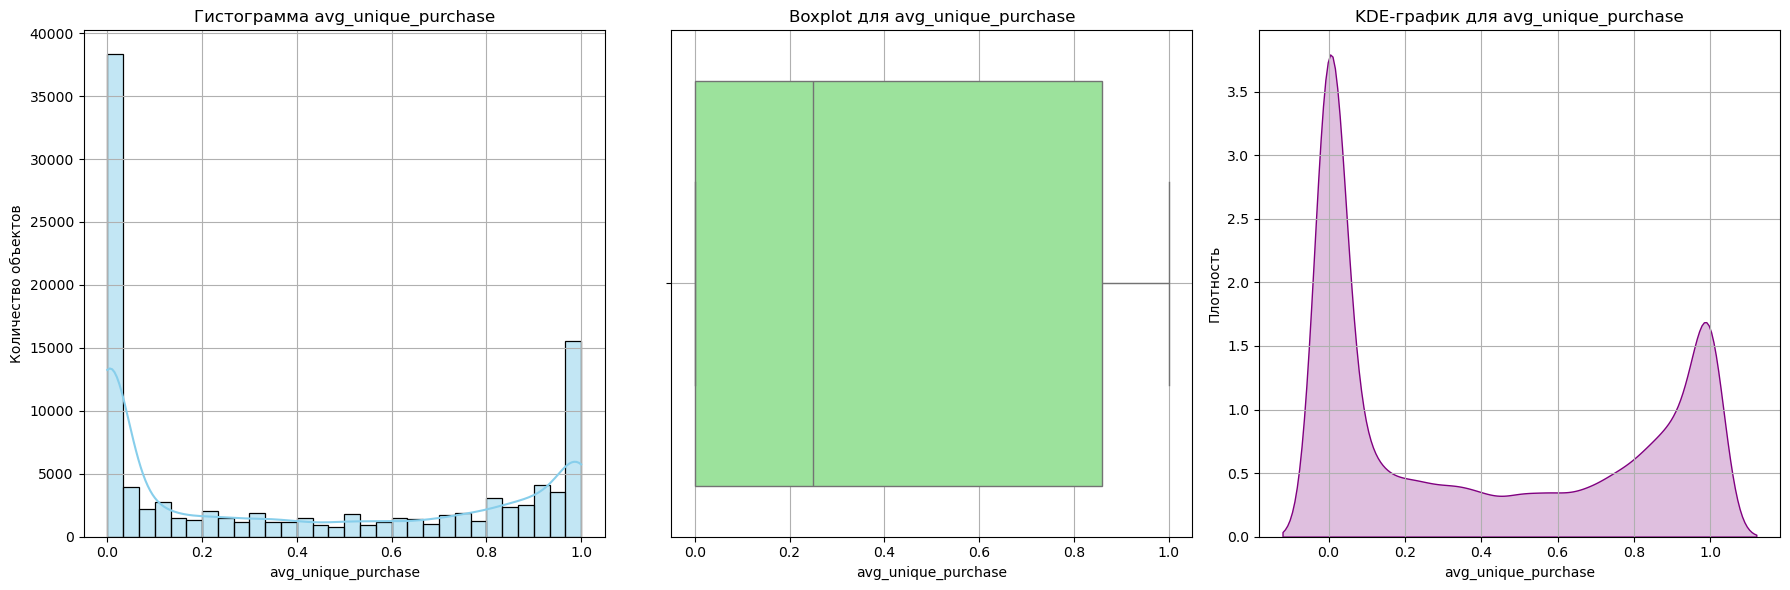

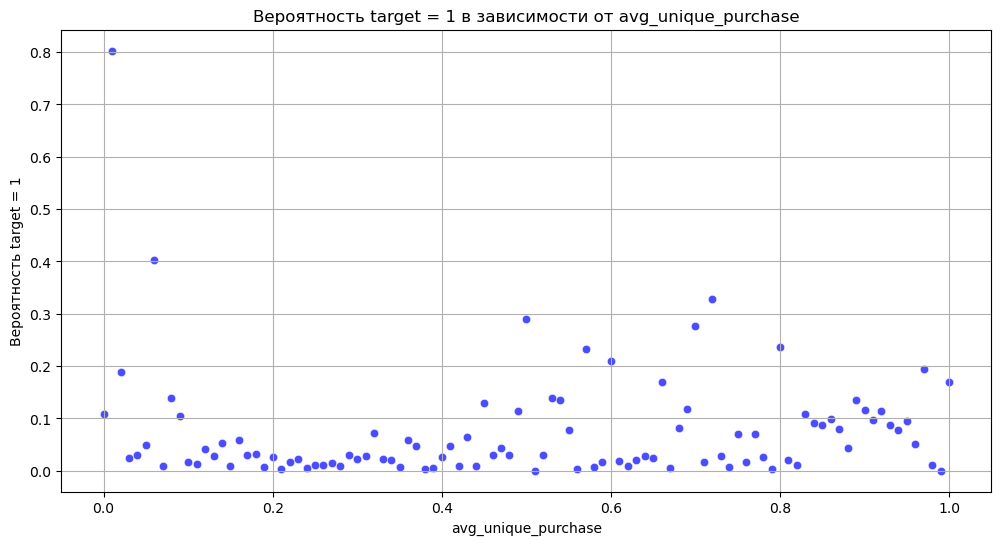

Статистика для признака 'NmAge':
count    105565.000000
mean      -9389.535575
std       17293.318159
min      -20000.000000
25%      -19847.000000
50%      -19637.000000
75%       20004.000000
max       20079.000000
Name: NmAge, dtype: float64
Медиана: -19637.0
0.95-й квантиль: 20063.0
0.85-й квантиль: 20053.0


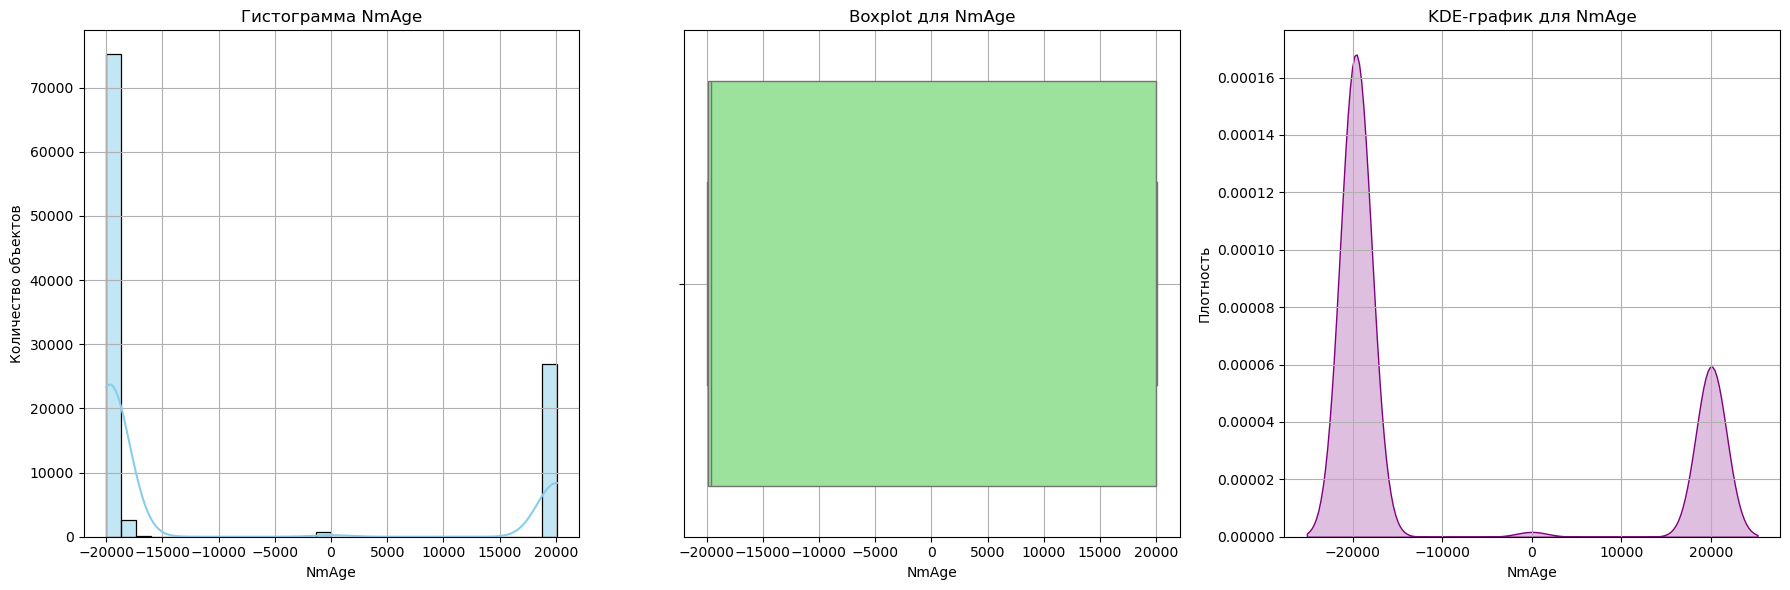

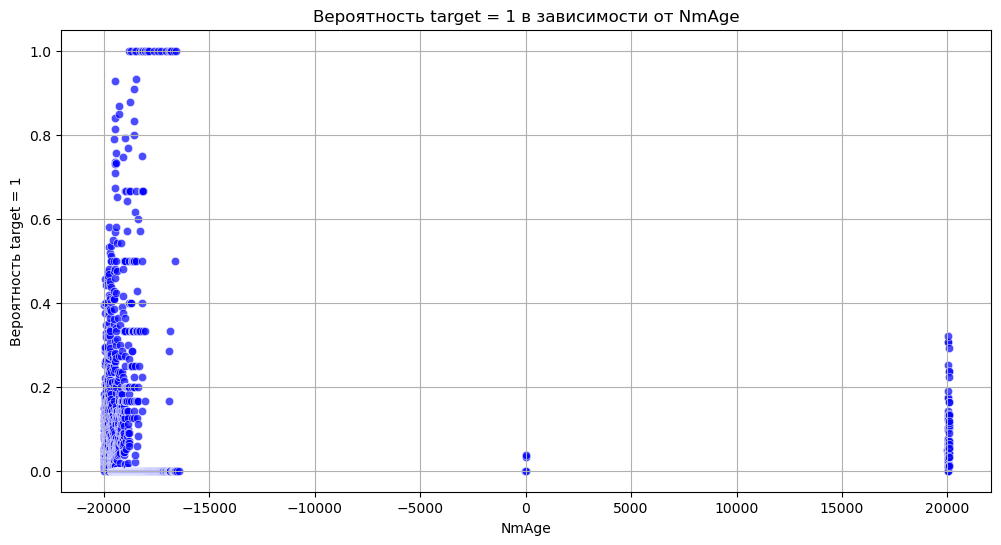

Статистика для признака 'Distance':
count    105565.000000
mean       1358.343381
std        1112.800395
min           6.000000
25%         472.000000
50%        1066.000000
75%        1995.000000
max        4653.000000
Name: Distance, dtype: float64
Медиана: 1066.0
0.95-й квантиль: 3587.0
0.85-й квантиль: 2889.0


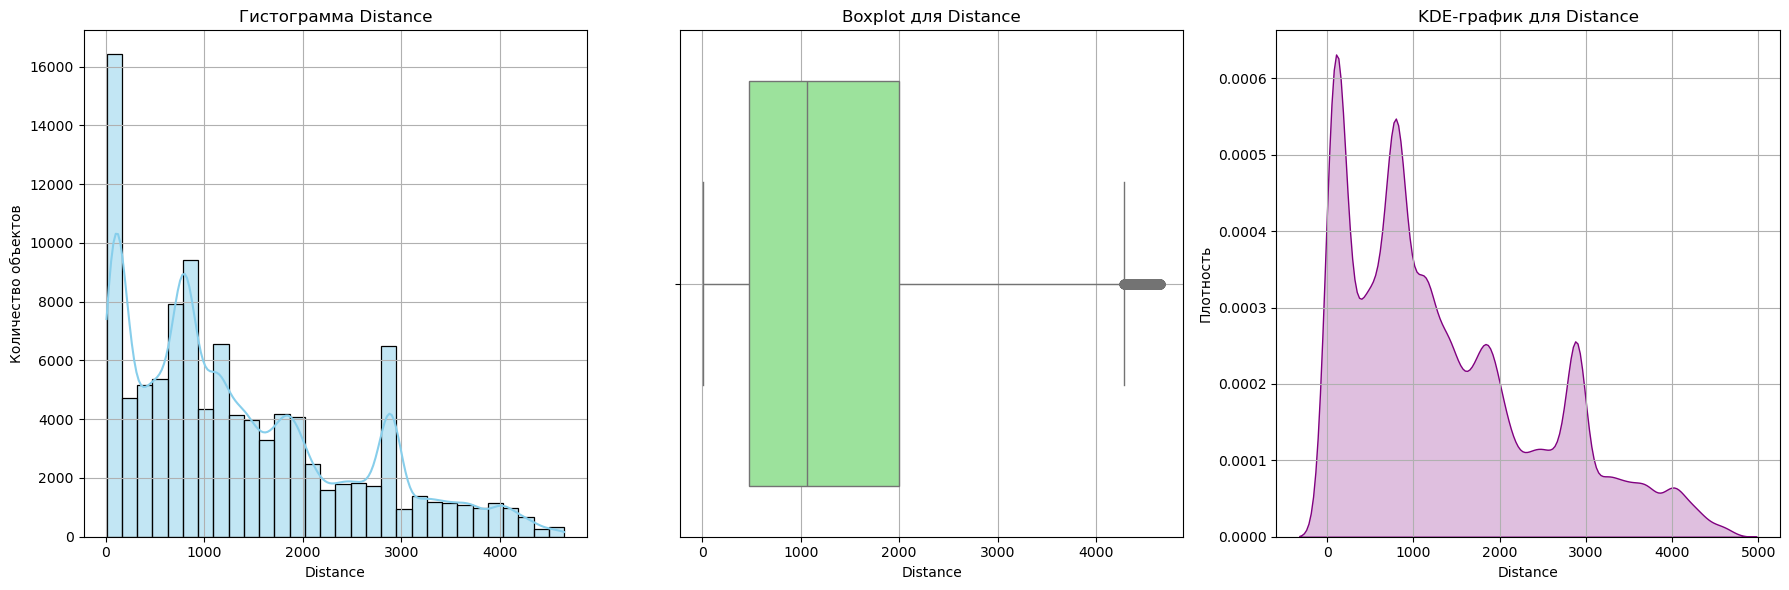

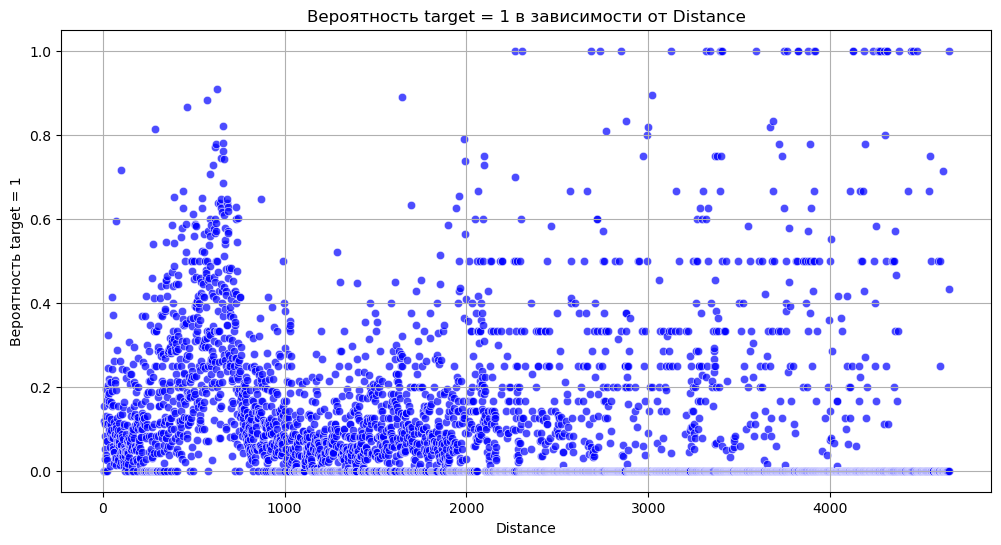

Статистика для признака 'DaysAfterRegistration':
count    105565.000000
mean       1281.238005
std         815.095686
min           0.000000
25%         551.000000
50%        1344.000000
75%        1843.000000
max        3341.000000
Name: DaysAfterRegistration, dtype: float64
Медиана: 1344.0
0.95-й квантиль: 2633.0
0.85-й квантиль: 2265.0


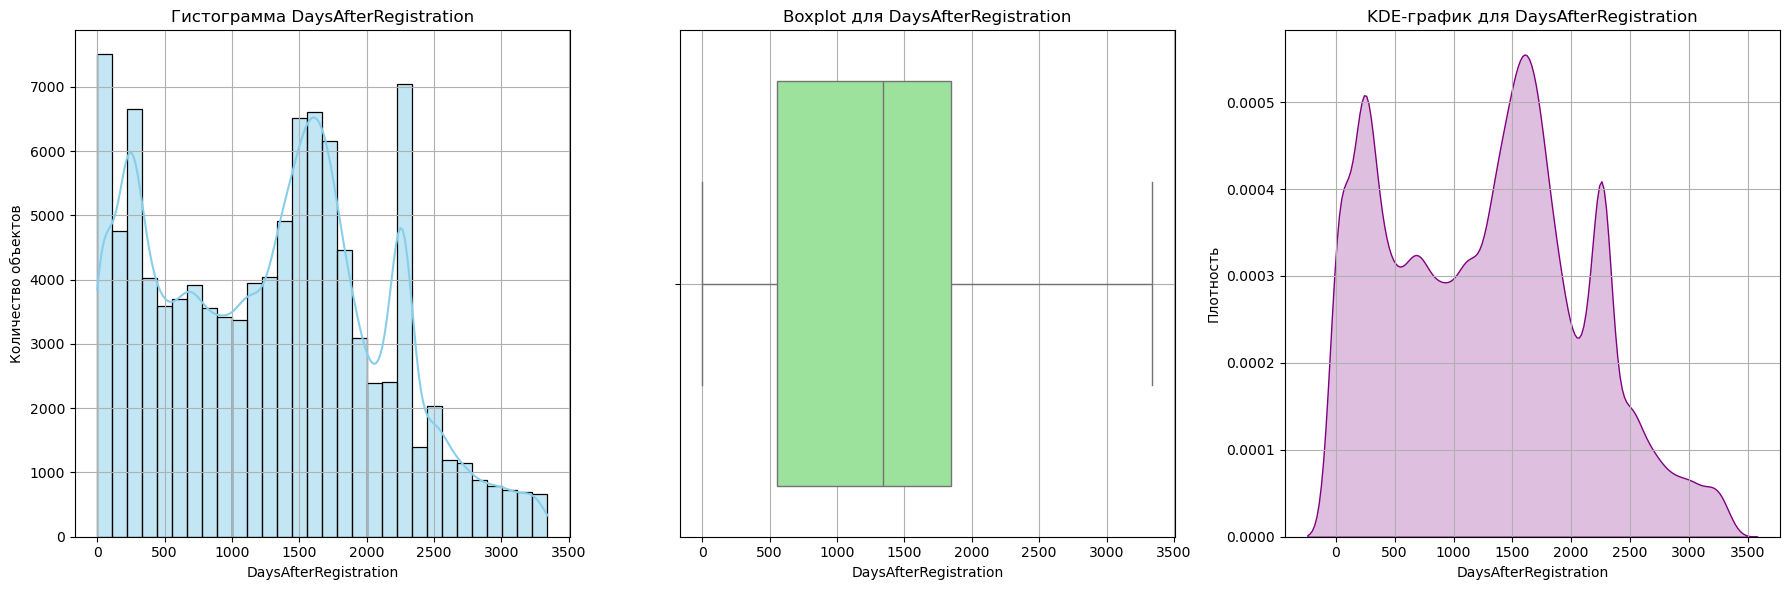

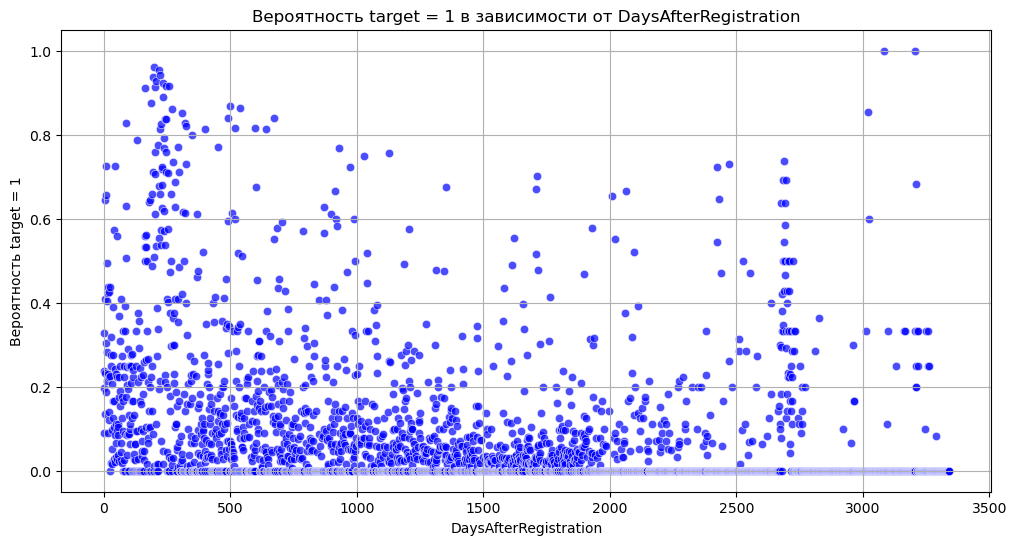

Статистика для признака 'number_of_orders':
count    105565.000000
mean         15.469019
std          21.122202
min           1.000000
25%           1.000000
50%           3.000000
75%          22.000000
max          79.000000
Name: number_of_orders, dtype: float64
Медиана: 3.0
0.95-й квантиль: 59.0
0.85-й квантиль: 51.0


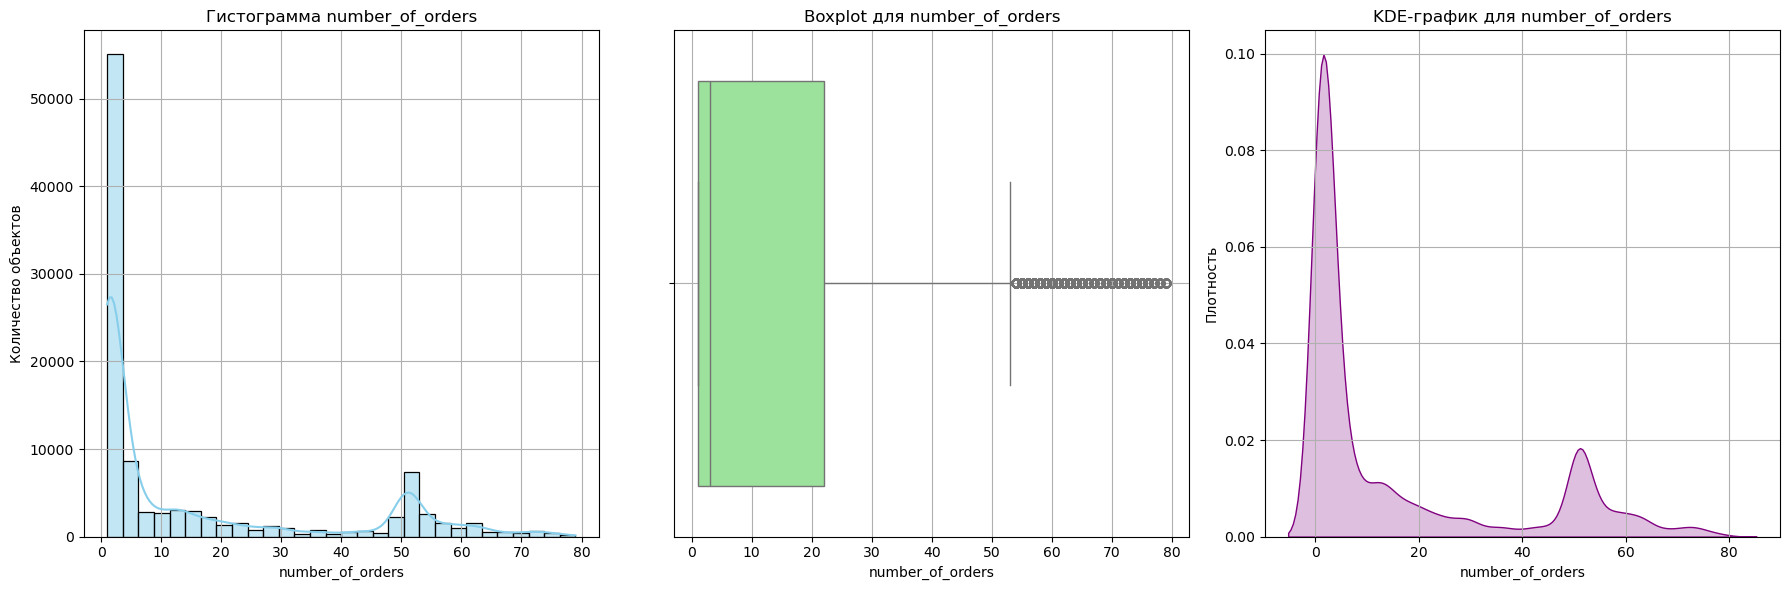

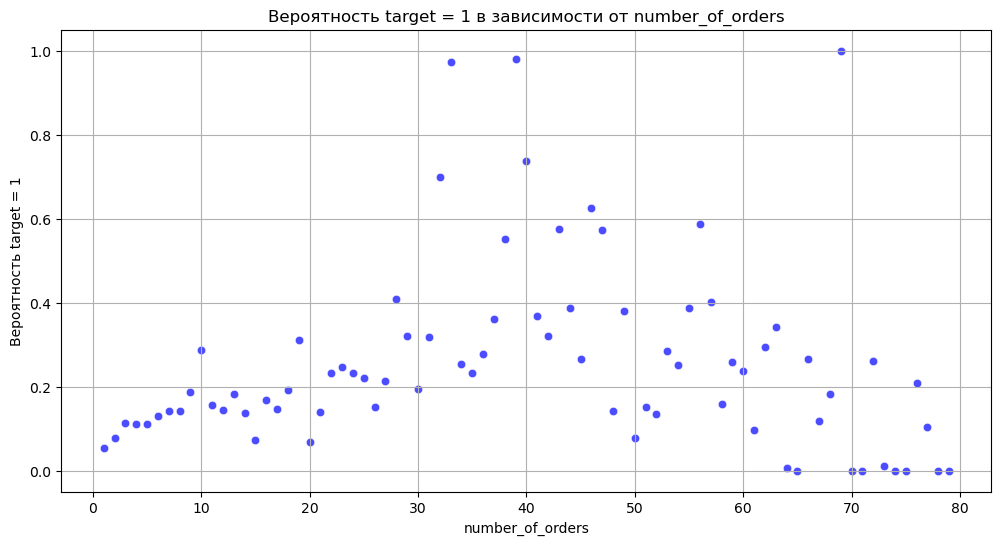

Статистика для признака 'number_of_ordered_items':
count    105565.000000
mean         68.766873
std          51.494369
min           1.000000
25%          27.000000
50%          56.000000
75%          94.000000
max         282.000000
Name: number_of_ordered_items, dtype: float64
Медиана: 56.0
0.95-й квантиль: 171.0
0.85-й квантиль: 126.0


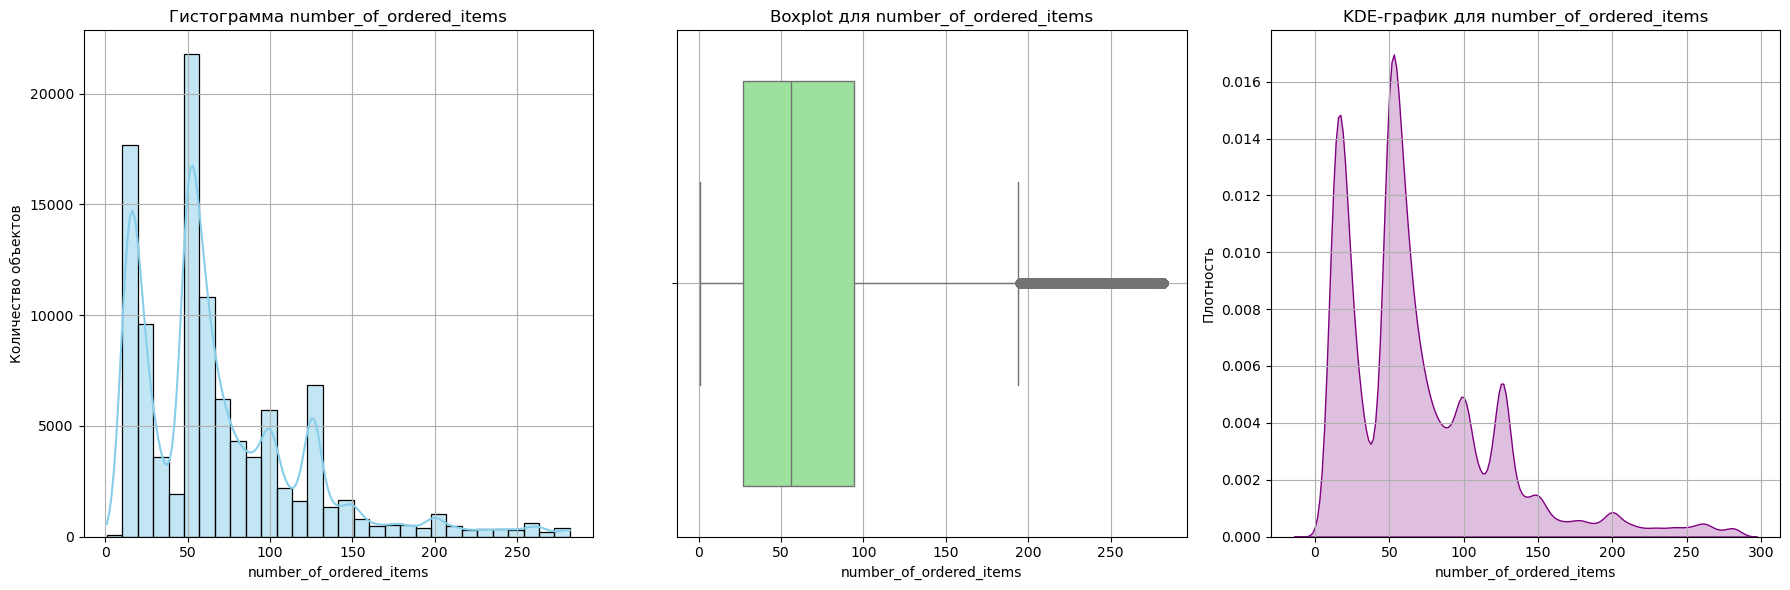

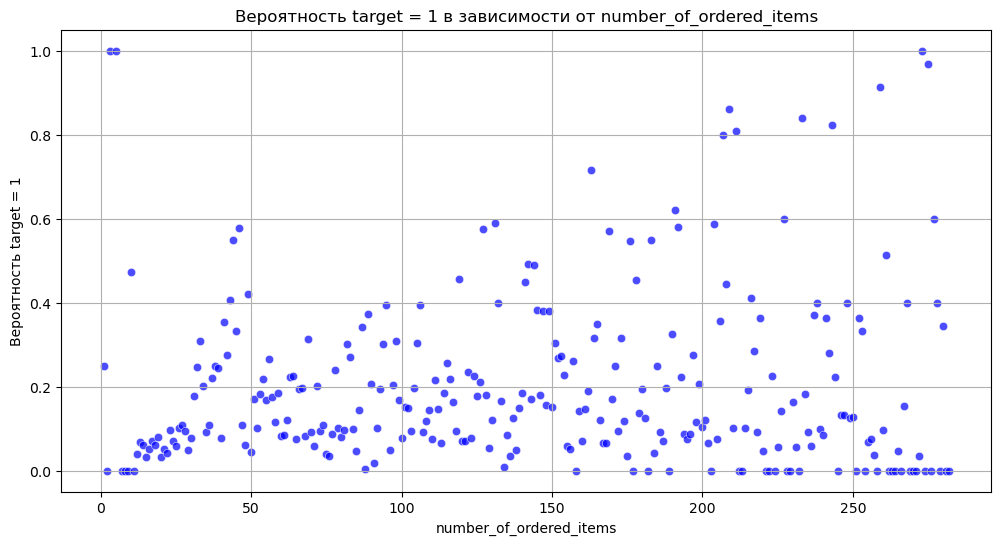

Статистика для признака 'mean_number_of_ordered_items':
count    105565.000000
mean         26.096987
std          27.639885
min           1.000000
25%           1.649123
50%          15.000000
75%          50.000000
max         100.000000
Name: mean_number_of_ordered_items, dtype: float64
Медиана: 15.0
0.95-й квантиль: 80.0
0.85-й квантиль: 62.0


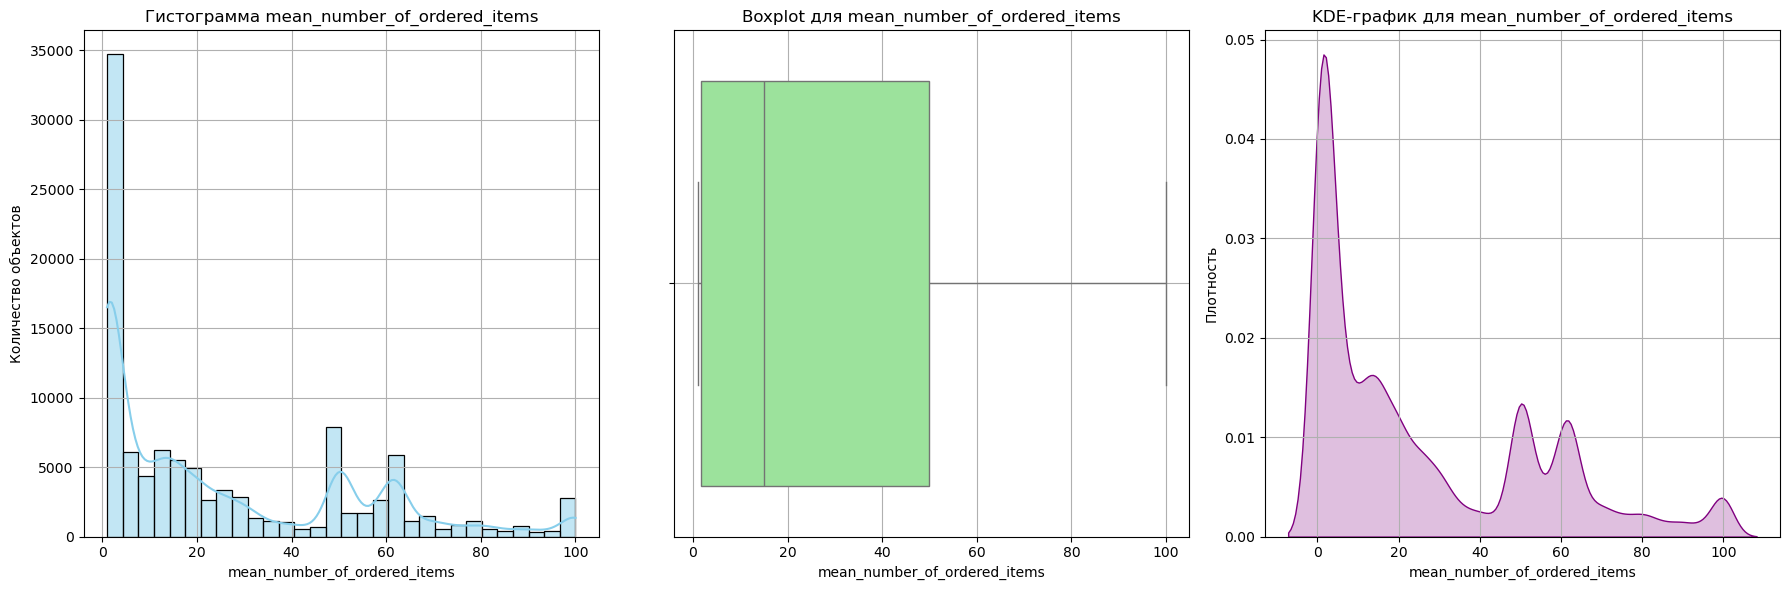

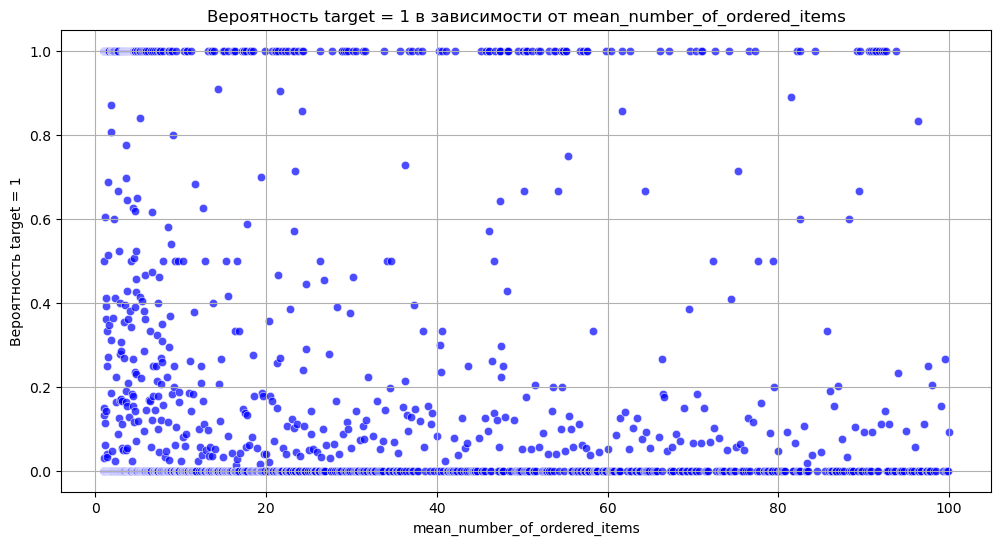

Статистика для признака 'max_number_of_ordered_items':
count    105565.000000
mean         31.011955
std          30.589747
min           1.000000
25%           3.000000
50%          20.000000
75%          50.000000
max         116.000000
Name: max_number_of_ordered_items, dtype: float64
Медиана: 20.0
0.95-й квантиль: 99.0
0.85-й квантиль: 72.0


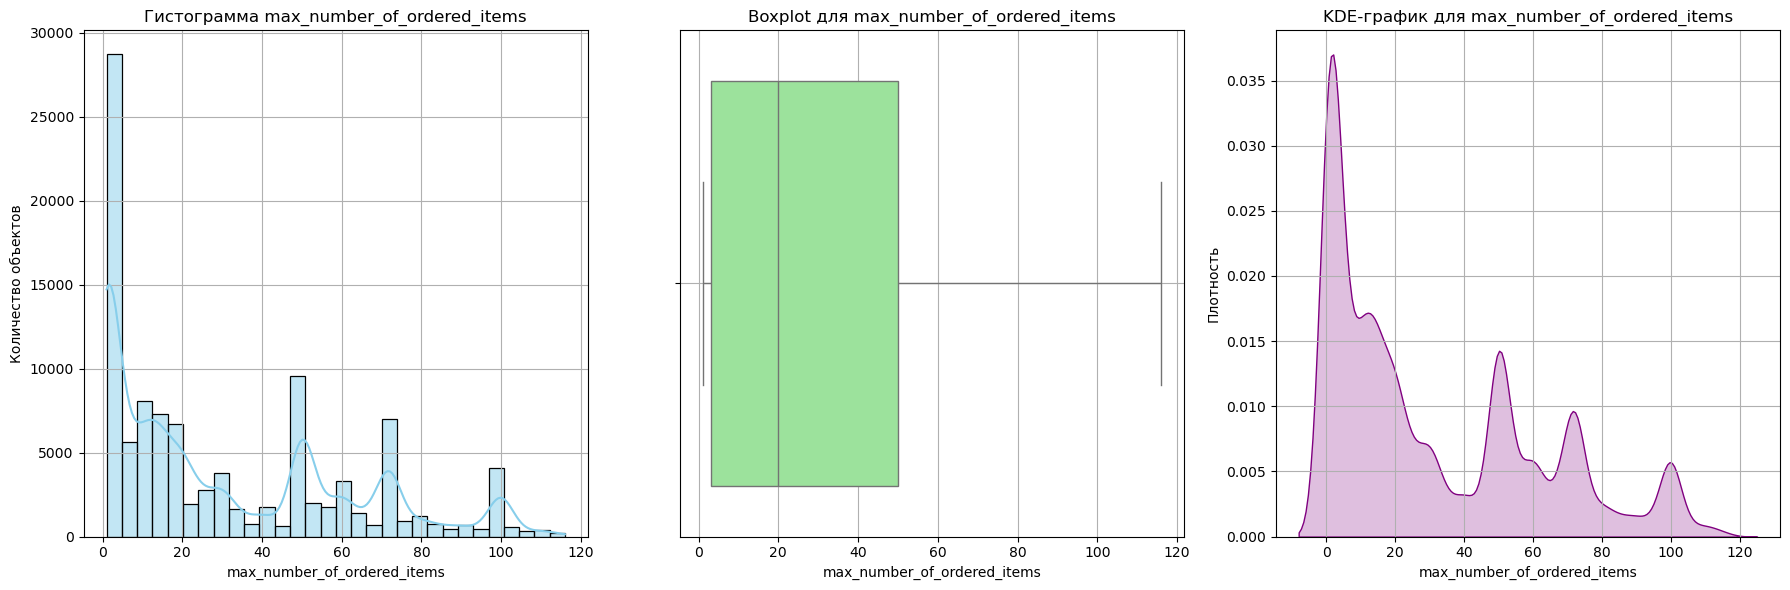

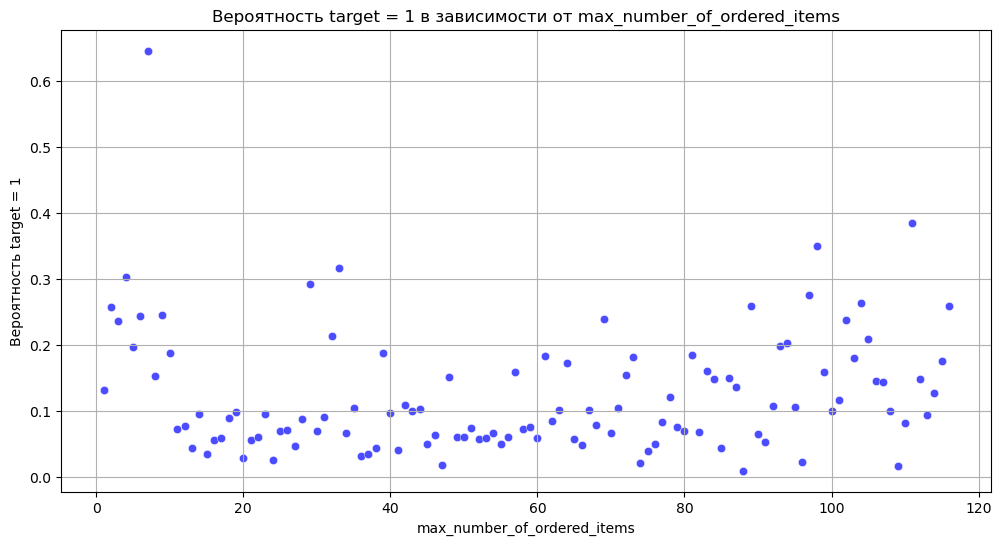

Статистика для признака 'mean_percent_of_ordered_items':
count    105565.000000
mean         45.643031
std          41.786504
min           0.041946
25%           4.545455
50%          33.333333
75%         100.000000
max         100.000000
Name: mean_percent_of_ordered_items, dtype: float64
Медиана: 33.33333333333333
0.95-й квантиль: 100.0
0.85-й квантиль: 100.0


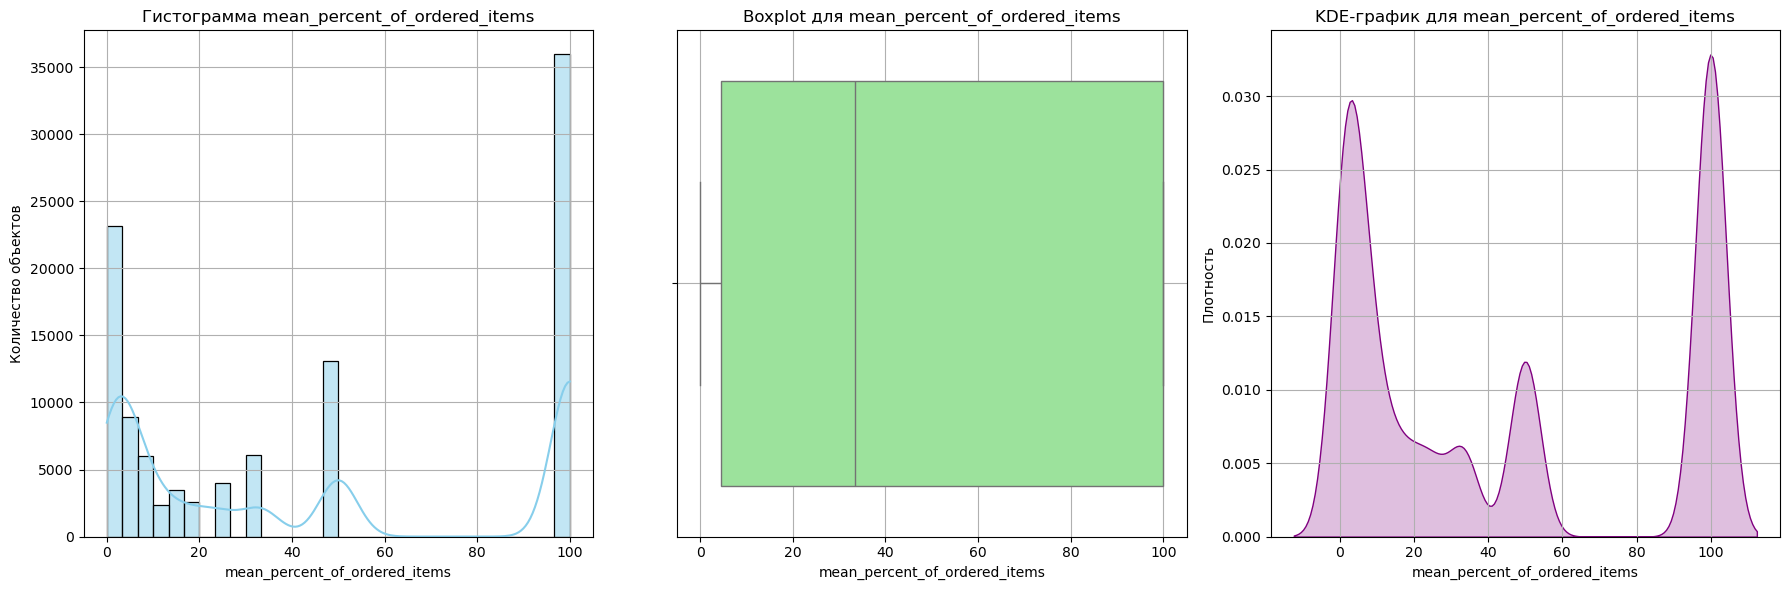

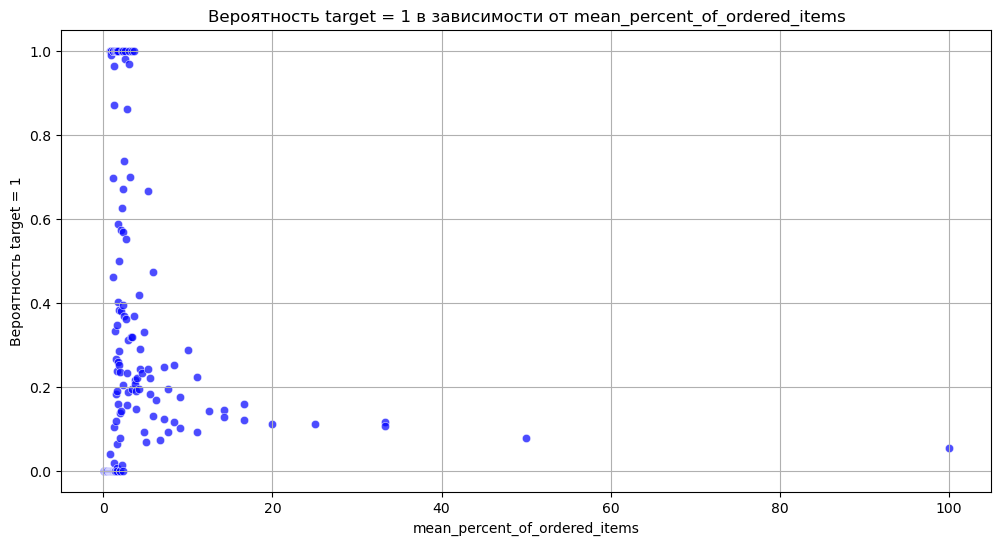

Статистика для признака 'dayofweek':
count    105565.000000
mean          2.730422
std           1.898998
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: dayofweek, dtype: float64
Медиана: 3.0
0.95-й квантиль: 6.0
0.85-й квантиль: 5.0


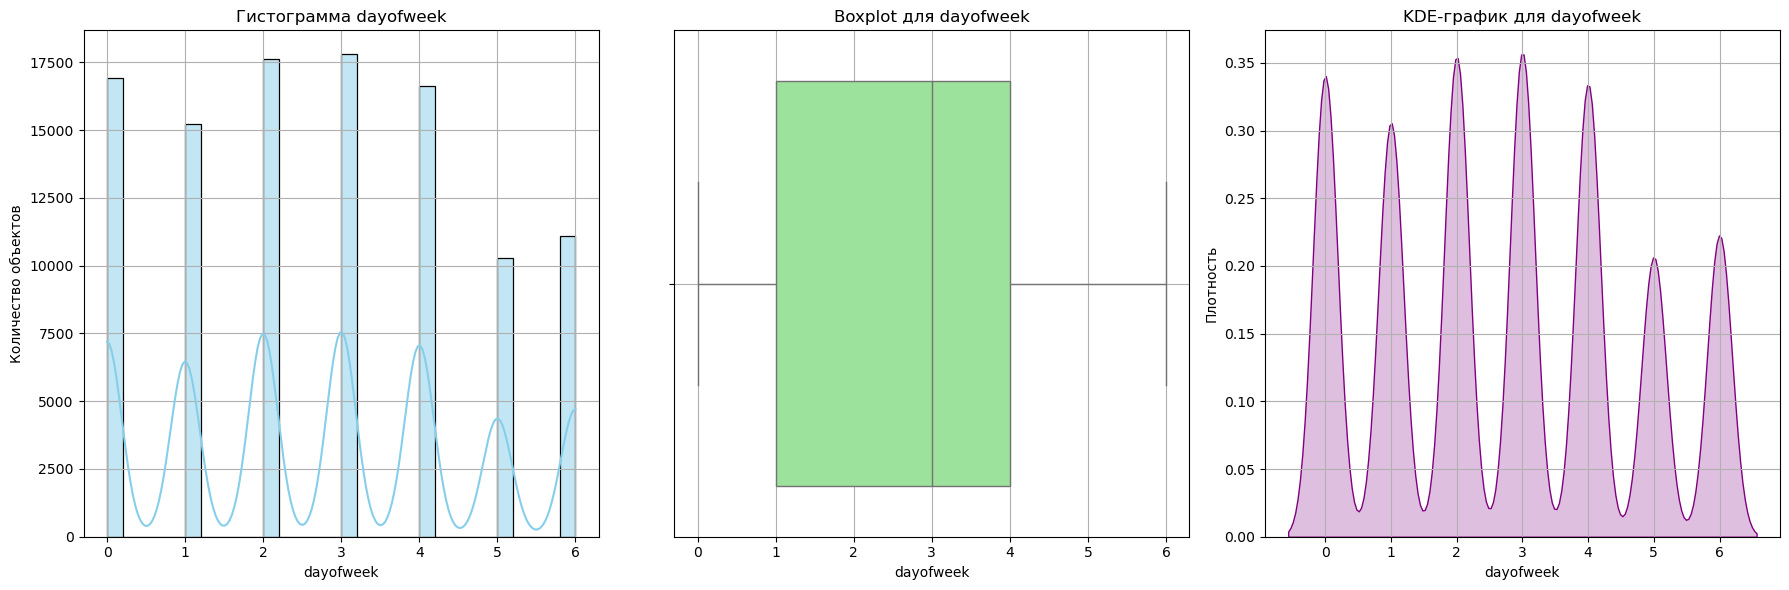

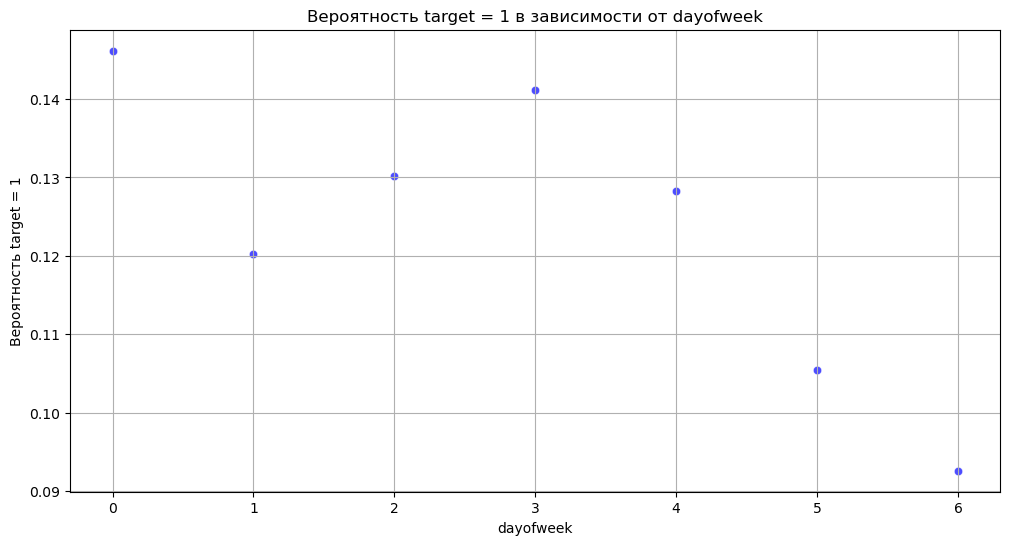

Статистика для признака 'hour':
count    105565.000000
mean          9.868583
std           5.248414
min           0.000000
25%           6.000000
50%          10.000000
75%          14.000000
max          23.000000
Name: hour, dtype: float64
Медиана: 10.0
0.95-й квантиль: 19.0
0.85-й квантиль: 16.0


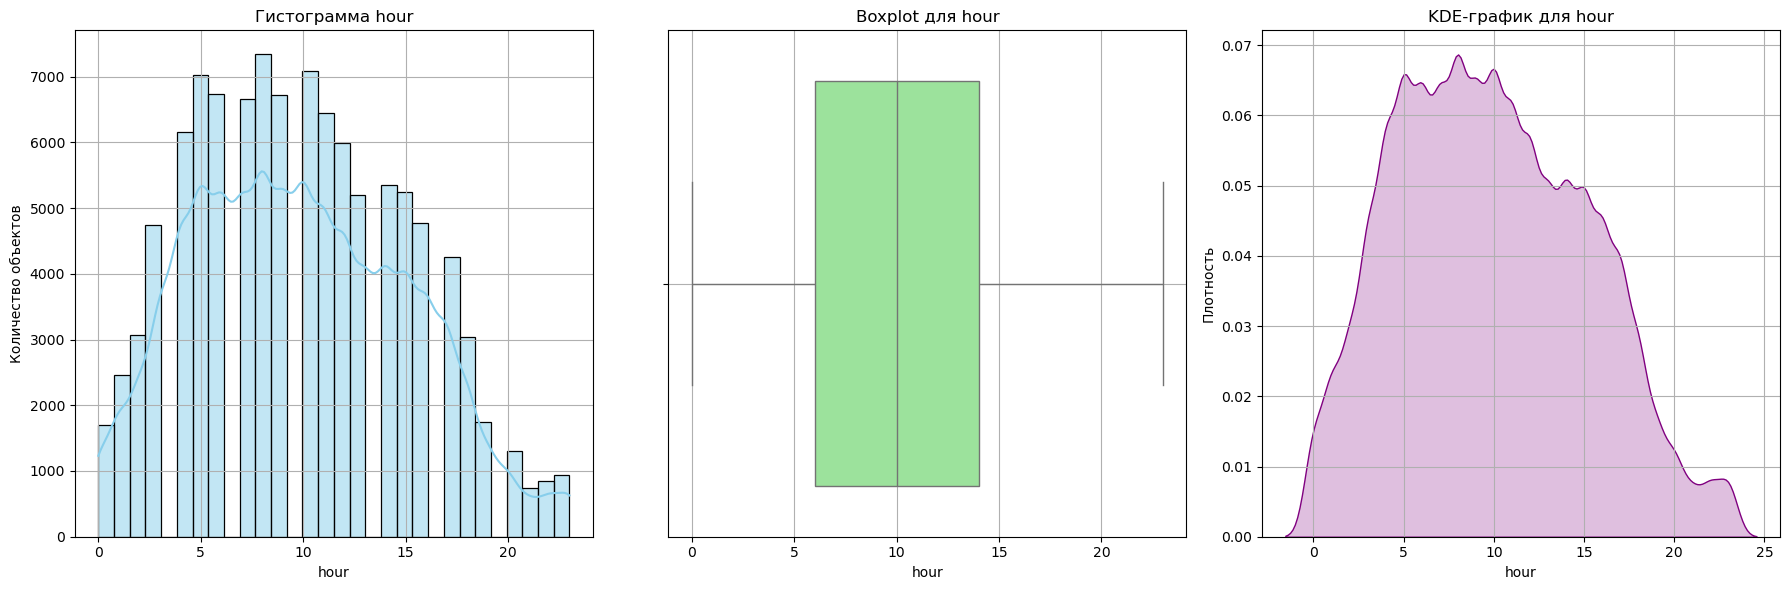

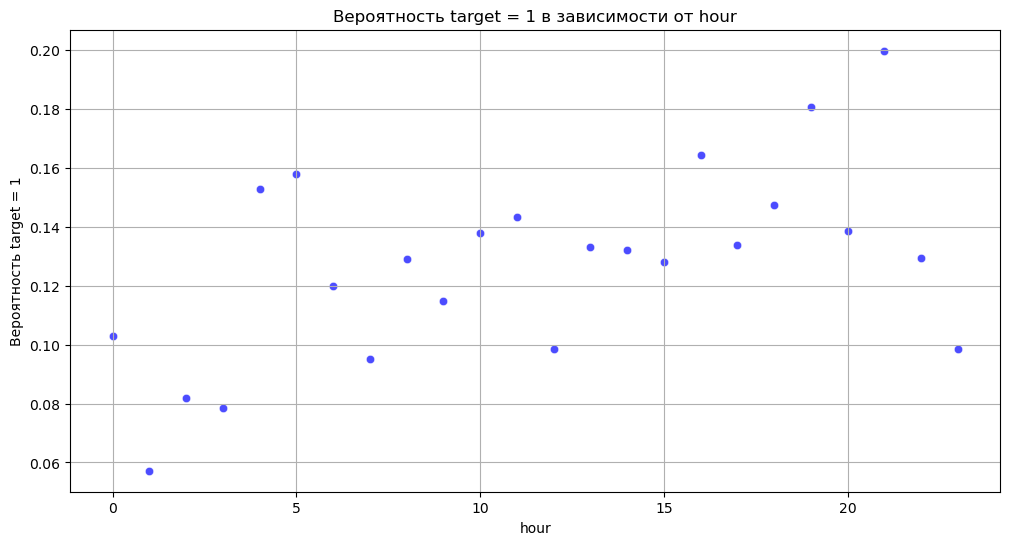

Статистика для признака 'user_number_of_orders_sum':
count    105565.000000
mean       5869.759627
std       20938.010766
min           1.000000
25%           2.000000
50%          18.000000
75%        1272.000000
max      112487.000000
Name: user_number_of_orders_sum, dtype: float64
Медиана: 18.0
0.95-й квантиль: 23666.0
0.85-й квантиль: 4386.0


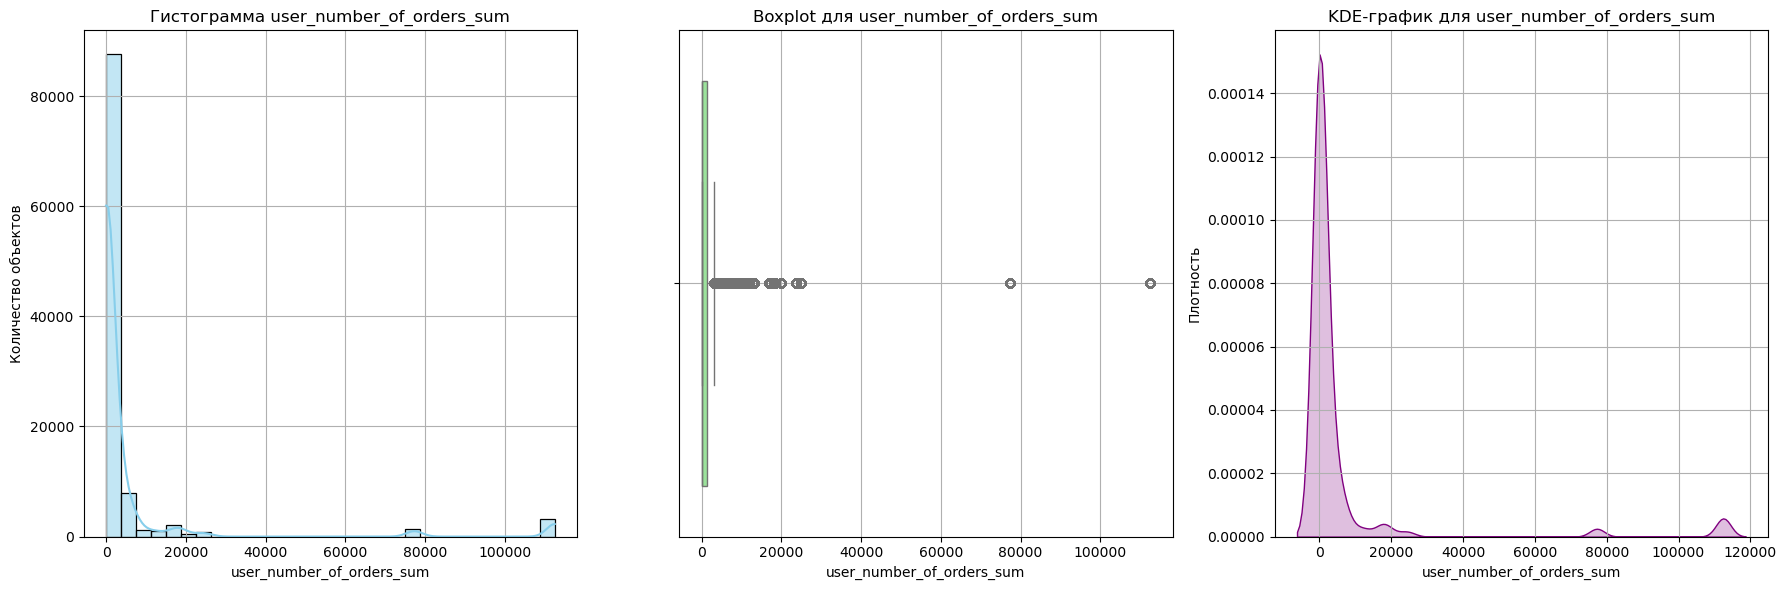

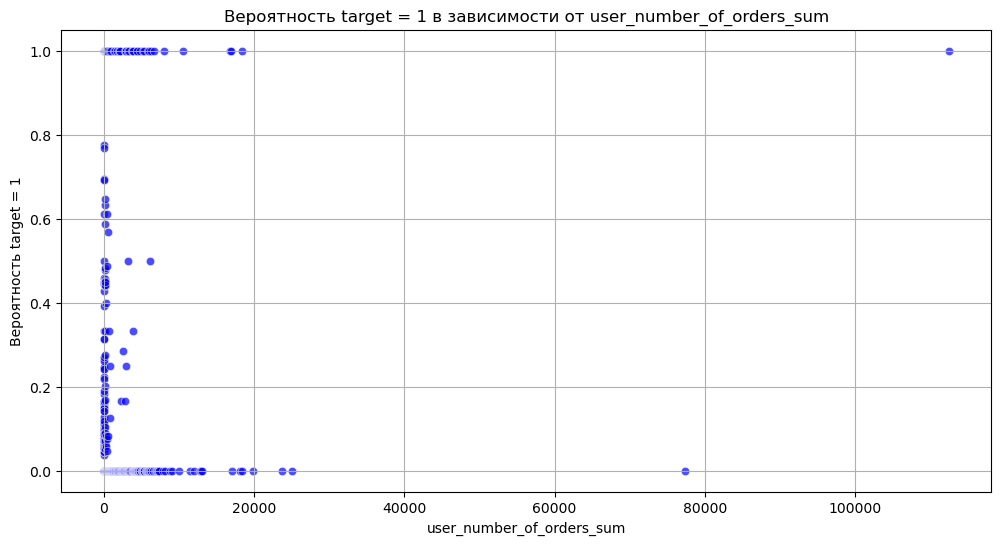

Статистика для признака 'user_total_ordered_sum':
count    105565.000000
mean        593.843452
std        2114.210399
min           1.000000
25%          50.000000
50%          83.000000
75%         206.000000
max       24750.000000
Name: user_total_ordered_sum, dtype: float64
Медиана: 83.0
0.95-й квантиль: 2606.0
0.85-й квантиль: 457.0


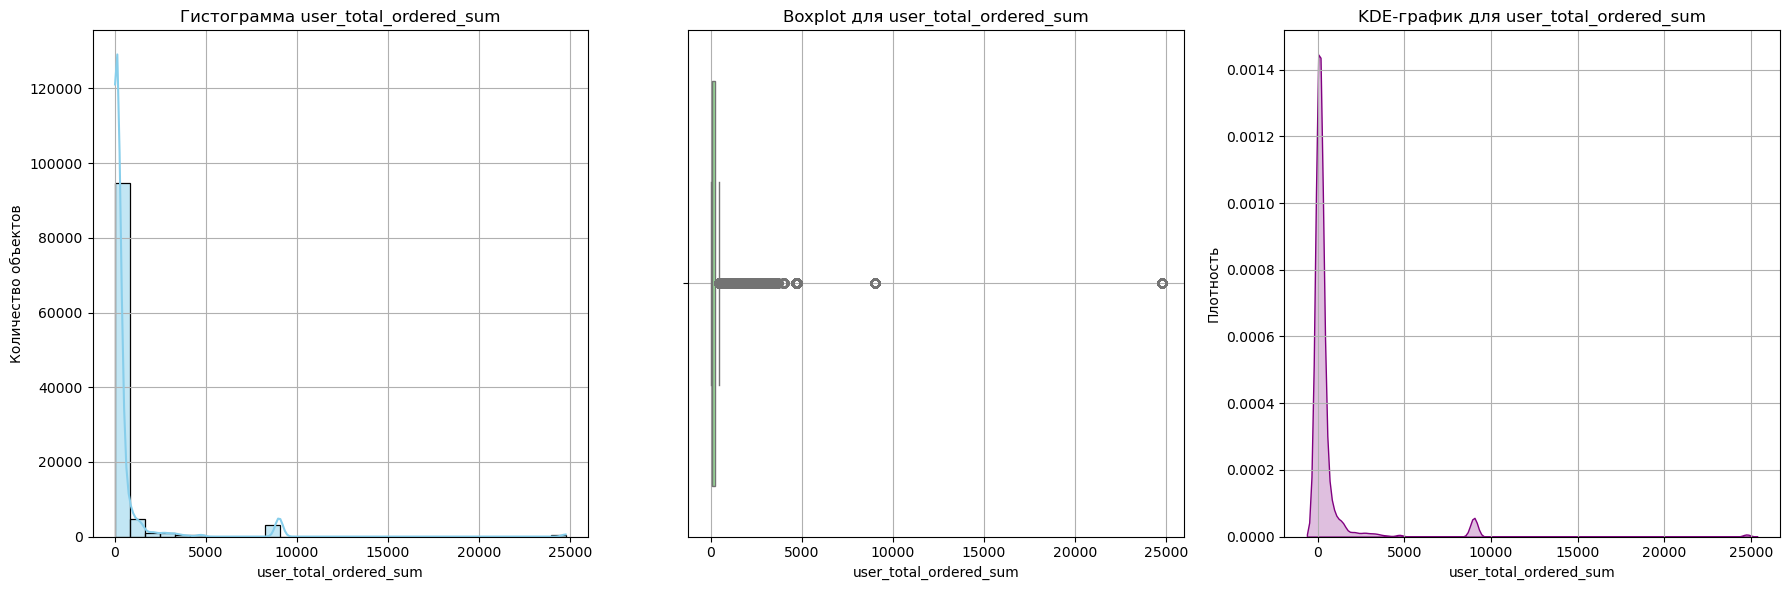

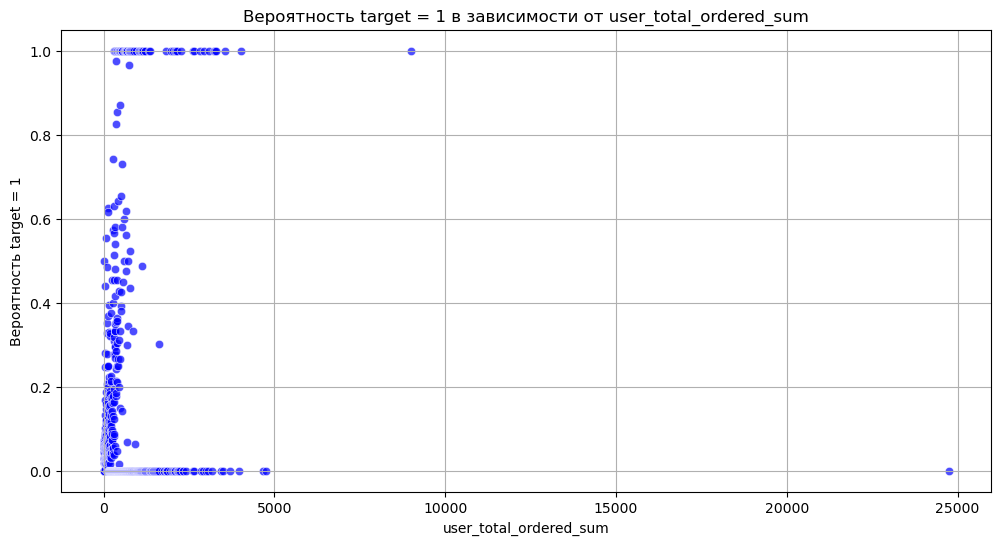

Статистика для признака 'user_distance_mean':
count    105565.000000
mean       1358.343381
std        1045.113500
min           6.000000
25%         605.337242
50%        1095.000000
75%        1927.000000
max        4653.000000
Name: user_distance_mean, dtype: float64
Медиана: 1095.0
0.95-й квантиль: 3468.0
0.85-й квантиль: 2696.5


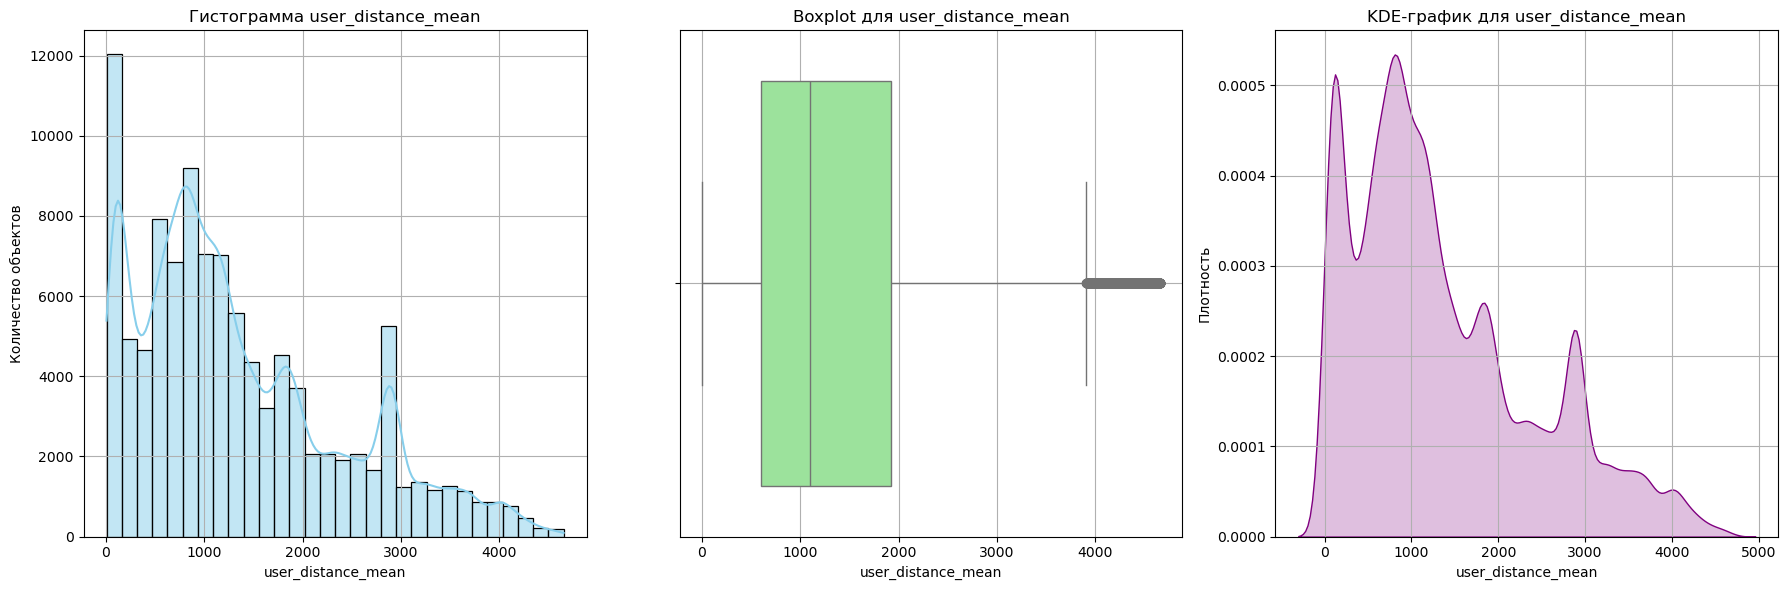

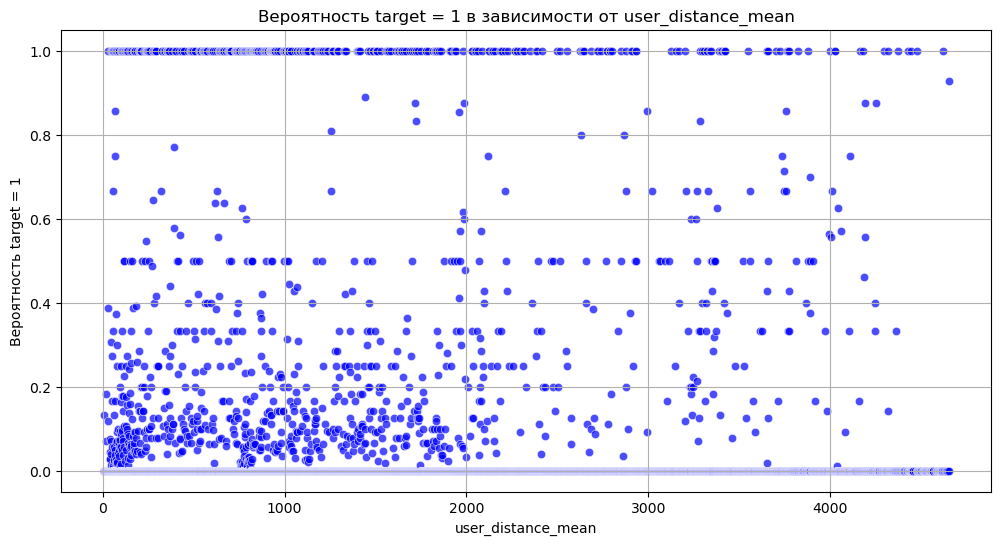

Статистика для признака 'user_distance_max':
count    105565.000000
mean       1763.771165
std        1227.111569
min           6.000000
25%         803.000000
50%        1586.000000
75%        2641.000000
max        4653.000000
Name: user_distance_max, dtype: float64
Медиана: 1586.0
0.95-й квантиль: 4107.0
0.85-й квантиль: 3165.0


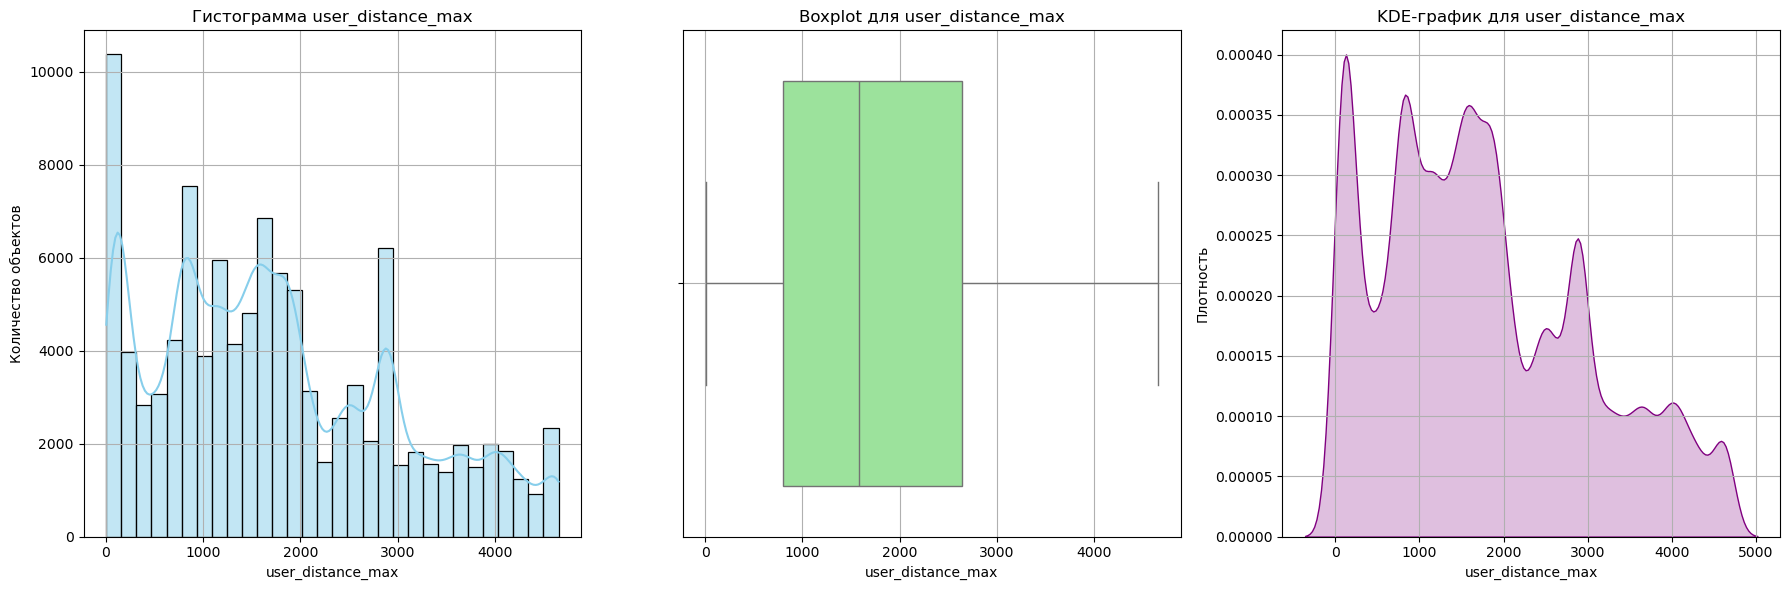

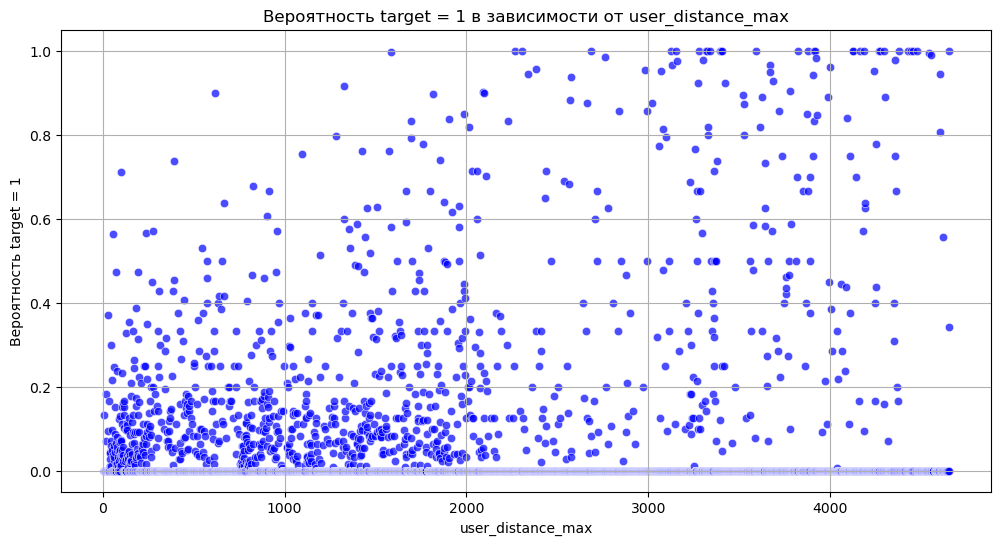

Статистика для признака 'time_since_last_order':
count    105565.000000
mean          1.216663
std           6.754704
min           0.000000
25%           0.000370
50%           0.000602
75%           0.001204
max         116.997986
Name: time_since_last_order, dtype: float64
Медиана: 0.0006018518518518
0.95-й квантиль: 4.795442129629592
0.85-й квантиль: 0.0062384259259259


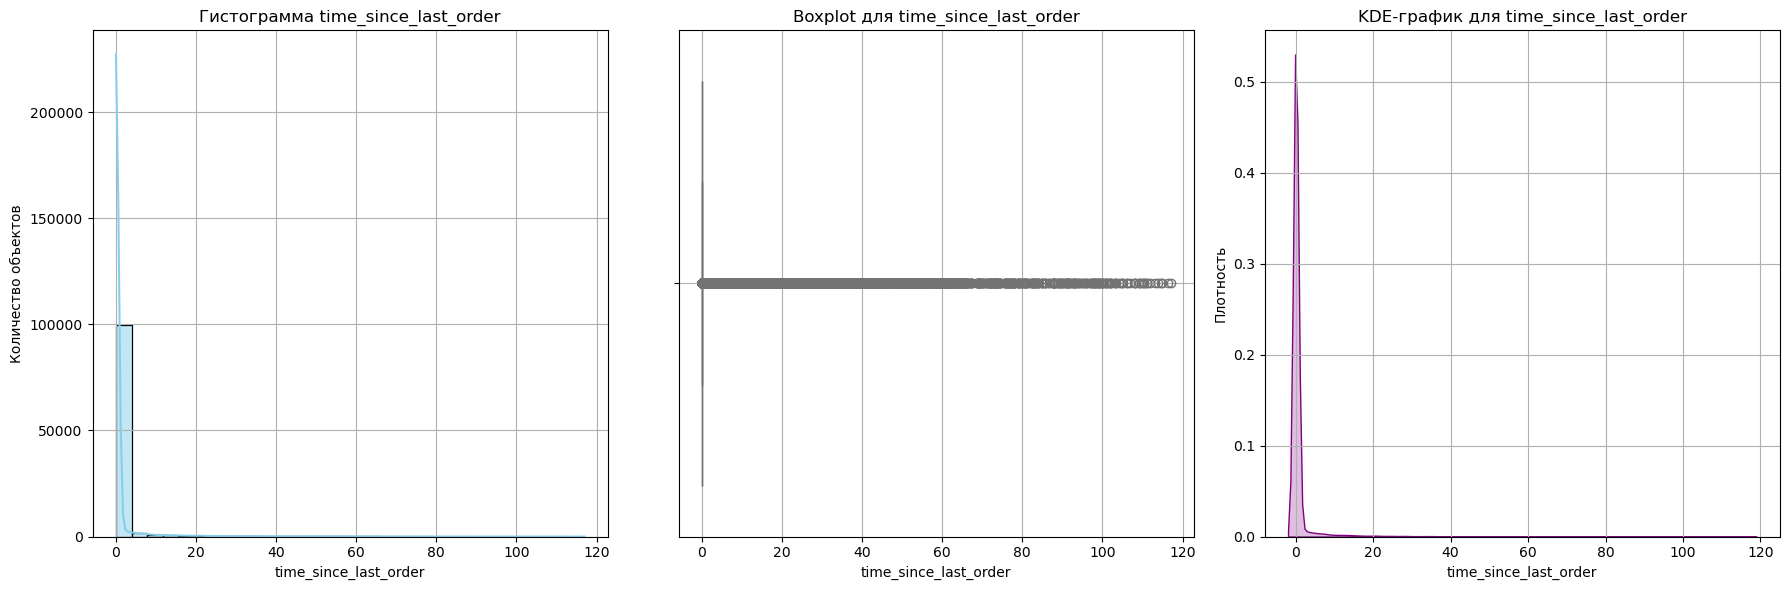

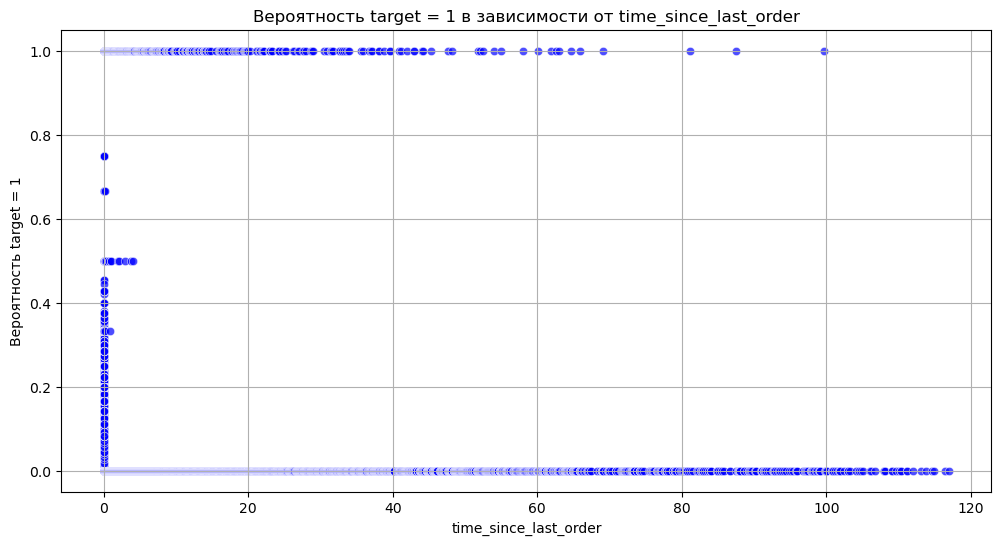

Статистика для признака 'orders_last_7d':
count    105565.000000
mean       1005.288221
std        2955.776562
min           1.000000
25%           1.000000
50%           8.000000
75%         310.000000
max       26941.000000
Name: orders_last_7d, dtype: float64
Медиана: 8.0
0.95-й квантиль: 5512.0
0.85-й квантиль: 1581.0


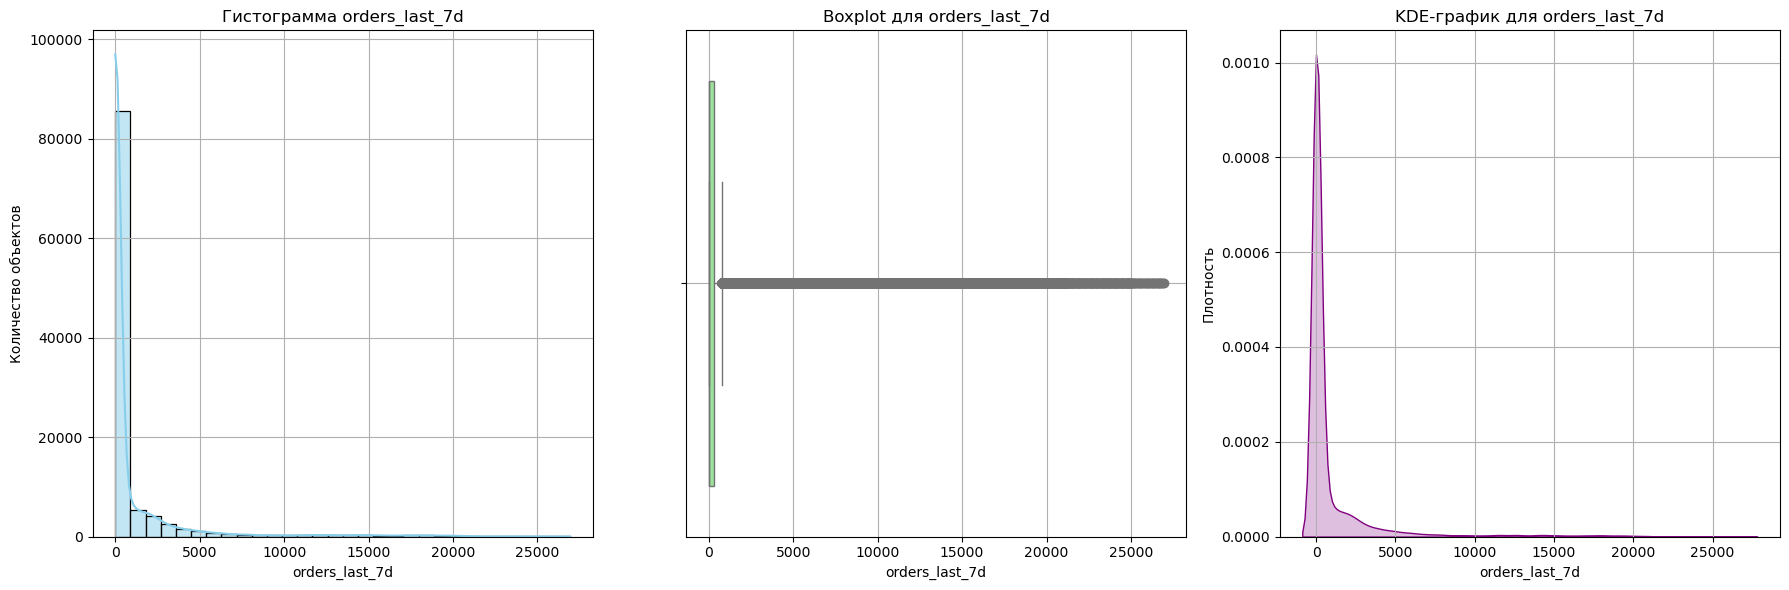

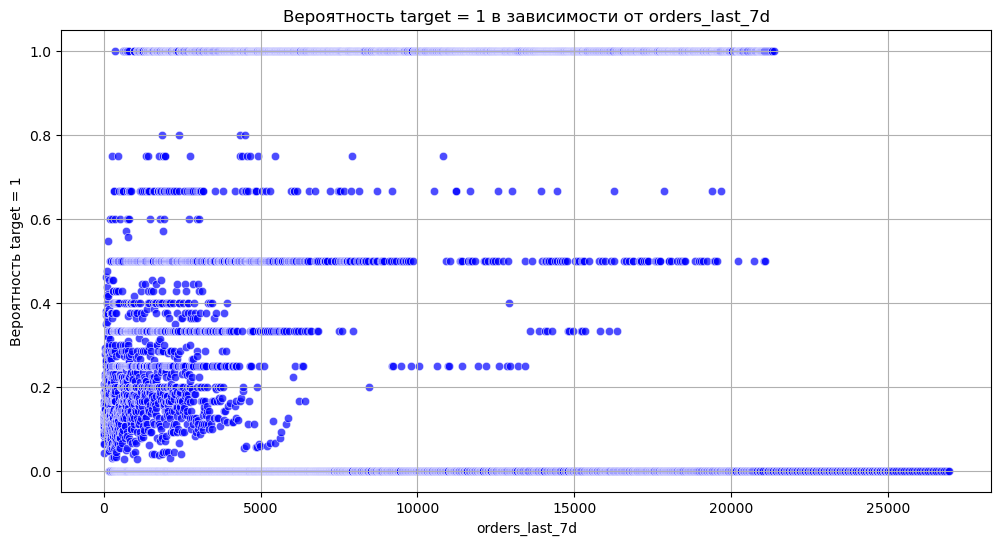

Статистика для признака 'orders_last_30d':
count    105565.000000
mean       2000.678909
std        7528.652810
min           1.000000
25%           1.000000
50%           9.000000
75%         373.000000
max       69585.000000
Name: orders_last_30d, dtype: float64
Медиана: 9.0
0.95-й квантиль: 9562.0
0.85-й квантиль: 1870.3999999999942


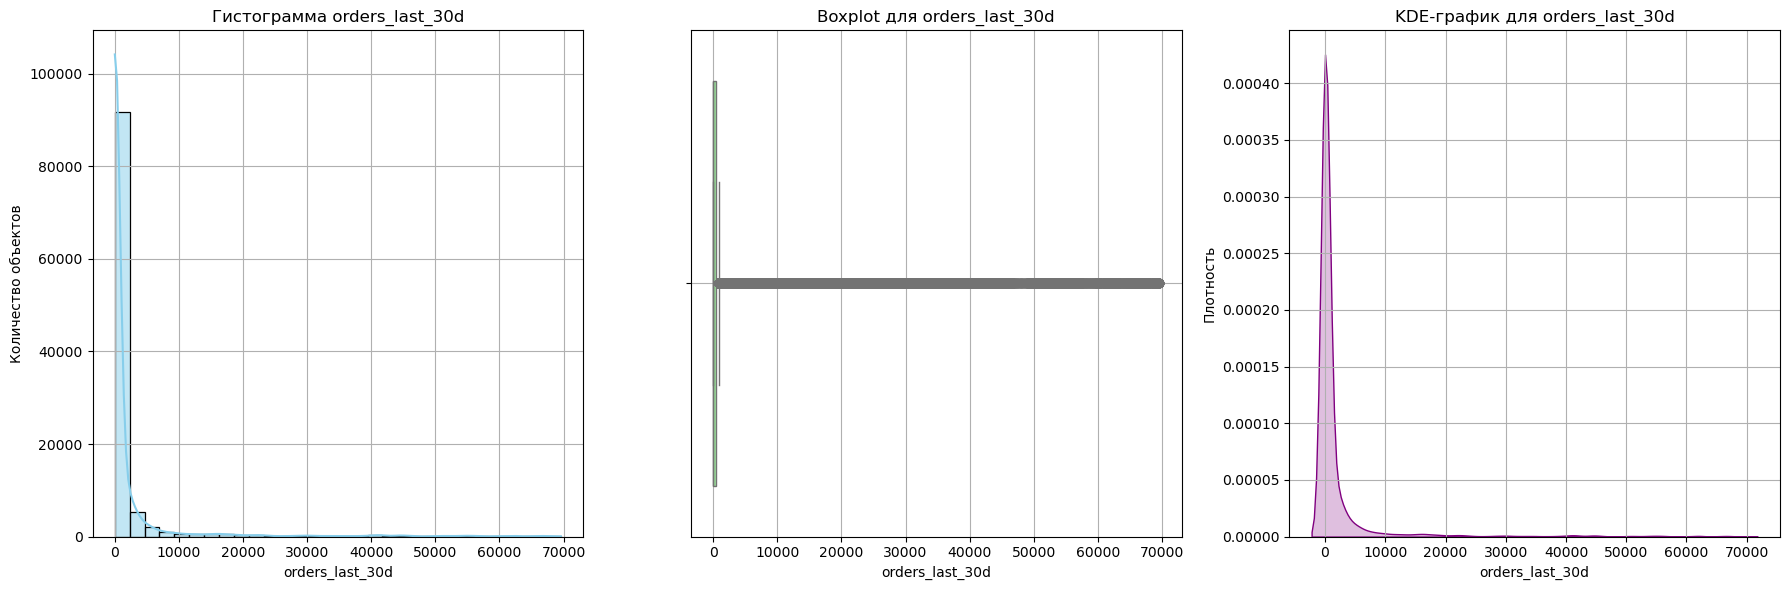

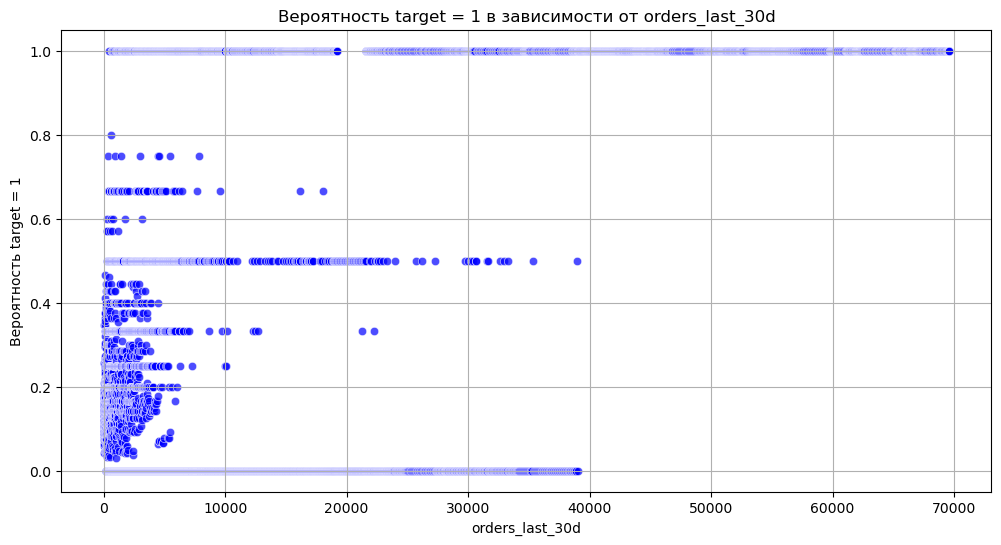

In [6]:
##Визуализация обратоннаых данных
df=get_df("train_prep")
for feature in ['service', 'total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase', 'NmAge', 'Distance', 'DaysAfterRegistration',
 'number_of_orders', 'number_of_ordered_items', 'mean_number_of_ordered_items', 'max_number_of_ordered_items',
 'mean_percent_of_ordered_items', 'dayofweek', 'hour', 'user_number_of_orders_sum', 'user_total_ordered_sum', 'user_distance_mean',
 'user_distance_max', 'time_since_last_order', 'orders_last_7d', 'orders_last_30d']:
    draw_graphs(df, feature)

In [10]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.metrics import (classification_report, confusion_matrix, precision_score, recall_score,
                             precision_recall_curve, auc, roc_auc_score,
                             average_precision_score, PrecisionRecallDisplay)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

now = datetime.now()
formatted_date = now.strftime("%Y-%m-%d %H:%M:%S")
print('Начало работы в:')
print(formatted_date)

# 1. Загрузка данных
train = get_df("train_prep")
test = pd.read_csv('df_test.csv')

# 2. Предобработка данных
test = adapt_df(test)

# 3. Подготовка данных
X = train.drop('target', axis=1)
y = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

# 4. Определение категориальных признаков
cat_features = ['PaymentType', 'service', 'IsPaid', 'dayofweek', 'hour']
# 5. Стратифицированное разделение данных
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# 6. Создание CatBoost Pool
train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_features
)
val_pool = Pool(
    X_val,
    y_val,
    cat_features=cat_features
)
test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)

# 7. Увеличение веса признака 'total_ordered'
feature_weights = {
    'total_ordered': 4.0,
    'user_total_ordered_sum': 1.0,
}

# 8. базовые параметры
base_params = {
    'silent': True,
    'eval_metric': 'Precision',
    'early_stopping_rounds': 100,
    'thread_count': -1,
    'feature_weights': feature_weights,
}

#Дополнительные параметры
param_grid = {
    'max_depth': 8,
    'n_estimators': 40,
    'learning_rate': 0.05,
    'l2_leaf_reg': 13,
    'min_data_in_leaf': 30,
    'subsample': 0.7,
    'bagging_temperature': 0.5
}

# 9. Обучаем модель 
model = CatBoostClassifier(**base_params, **param_grid)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    verbose=False
)

now = datetime.now()
formatted_date = now.strftime("%Y-%m-%d %H:%M:%S")
print('Конец работы в:')
print(formatted_date)


# Конец обучения


Начало работы в:
2025-05-12 17:42:47
Конец работы в:
2025-05-12 17:43:02


Precision: 0.9378969654199012
Recall: 0.49756645451141895
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18442
           1       0.94      0.50      0.65      2671

    accuracy                           0.93     21113
   macro avg       0.93      0.75      0.81     21113
weighted avg       0.93      0.93      0.92     21113


Confusion Matrix:
[[18354    88]
 [ 1342  1329]]

PR-AUC: 0.750
ROC-AUC: 0.746


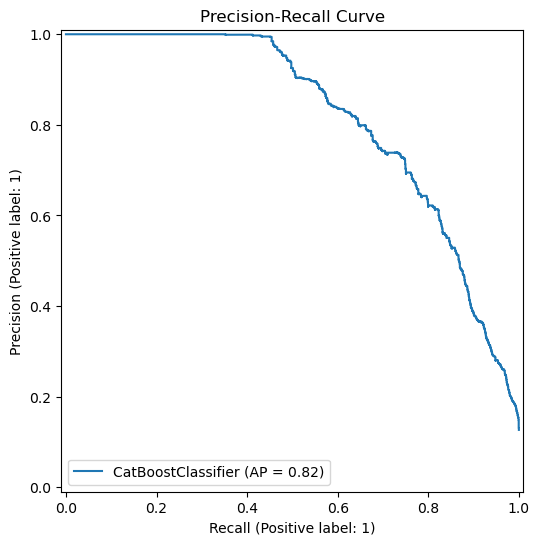

In [13]:
# ВАЛИДАЦИОННАЯ ВЫБОРКА

thresholds = np.linspace(0, 1, 100)
best_precision = 0
best_threshold = 0.5 

# 10. Предсказываем значения и их вероятности
y_val_proba = model.predict_proba(X_val)[:, 1]

# 11. Предсказываем вероятности на валидации, чуть чуть снизив порог определения target
y_val_pred = (y_val_proba >= 0.45).astype(int)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec  = recall_score(y_val, y_val_pred)

print("Precision:", prec)
print("Recall:", rec)

# 12. Оценка метрик на VAL
print("Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
pr_auc = auc(recall, precision)
print(f"\nPR-AUC: {pr_auc:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"ROC-AUC: {roc_auc:.3f}")

# 13. Визуализация
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# PR Curve
PrecisionRecallDisplay.from_estimator(model, X_val, y_val, ax=ax1)
ax1.set_title('Precision-Recall Curve')

plt.show()

Precision: 0.9039145907473309
Recall: 0.1406423034330011
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12455
           1       0.90      0.14      0.24      1806

    accuracy                           0.89     14261
   macro avg       0.90      0.57      0.59     14261
weighted avg       0.89      0.89      0.85     14261


Confusion Matrix:
[[12428    27]
 [ 1552   254]]

PR-AUC: 0.577
ROC-AUC: 0.780


Text(0.5, 1.0, 'Precision-Recall Curve')

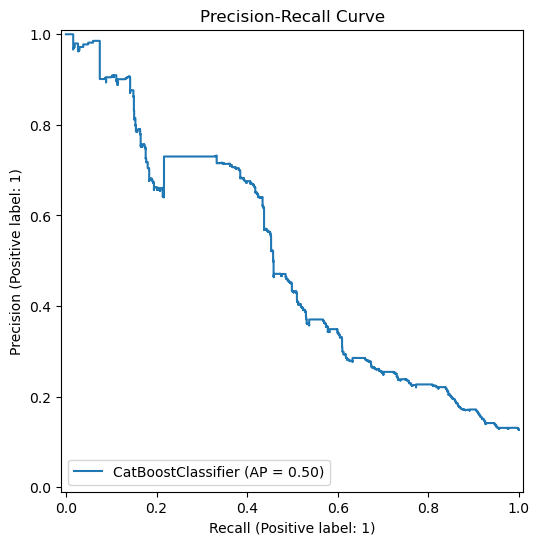

In [14]:
# ТЕСТОВАЯ ВЫБОРКА
thresholds = np.linspace(0, 1, 100)
best_precision = 0
best_threshold = 0.5 

# 10. Предсказываем значения и их вероятности
y_test_proba = model.predict_proba(X_test)[:, 1]

# 11. Предсказываем вероятности на тесте, чуть чуть снизив порог определения target
y_test_pred = (y_test_proba >= 0.45).astype(int)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec  = recall_score(y_test, y_test_pred)

print("Precision:", prec)
print("Recall:", rec)

# 12. Оценка метрик на TEST
print("Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = auc(recall, precision)
print(f"\nPR-AUC: {pr_auc:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC: {roc_auc:.3f}")

# 13. Визуализация
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# PR Curve
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax1)
ax1.set_title('Precision-Recall Curve')

# plt.show()